# Progetto di Machine Learning

## Authors
 - Metelli Claudio
 - Cherubini Mattia
 - Bernocchi Alessandro

## Mission

Rilevazione del fumo con l'aiuto dei dati IoT raccolti da diversi sensori e attivazione di un allarme antincendio, utilizzando il seguente dataset [Smoke detection](https://www.kaggle.com/datasets/deepcontractor/smoke-detection-dataset).

# Imports

In [58]:
import time
from typing import List
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

from scipy.stats import zscore

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import ExtraTreeClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

# Loading Dataset

Come prima cosa importiamo il dataset e stampiamo alcune righe; analizziamo poi il dataset, notando i tipi di ogni colonna ed alcune informazioni ad essa relative. 

In [59]:
dataset = pd.read_csv("smoke_detection_iot.csv")
dataset.head()

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0
2,2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2,0
3,3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,3,0
4,4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,4,0


In [60]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,62630.0,3.131450e+04,18079.868017,0.000000e+00,1.565725e+04,3.131450e+04,4.697175e+04,6.262900e+04
UTC,62630.0,1.654792e+09,110002.488078,1.654712e+09,1.654743e+09,1.654762e+09,1.654778e+09,1.655130e+09
Temperature[C],62630.0,1.597042e+01,14.359576,-2.201000e+01,1.099425e+01,2.013000e+01,2.540950e+01,5.993000e+01
Humidity[%],62630.0,4.853950e+01,8.865367,1.074000e+01,4.753000e+01,5.015000e+01,5.324000e+01,7.520000e+01
TVOC[ppb],62630.0,1.942058e+03,7811.589055,0.000000e+00,1.300000e+02,9.810000e+02,1.189000e+03,6.000000e+04
eCO2[ppm],62630.0,6.700210e+02,1905.885439,4.000000e+02,4.000000e+02,4.000000e+02,4.380000e+02,6.000000e+04
Raw H2,62630.0,1.294245e+04,272.464305,1.066800e+04,1.283000e+04,1.292400e+04,1.310900e+04,1.380300e+04
Raw Ethanol,62630.0,1.975426e+04,609.513156,1.531700e+04,1.943500e+04,1.950100e+04,2.007800e+04,2.141000e+04
Pressure[hPa],62630.0,9.386276e+02,1.331344,9.308520e+02,9.387000e+02,9.388160e+02,9.394180e+02,9.398610e+02
PM1.0,62630.0,1.005943e+02,922.524245,0.000000e+00,1.280000e+00,1.810000e+00,2.090000e+00,1.433369e+04


In [61]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      62630 non-null  int64  
 1   UTC             62630 non-null  int64  
 2   Temperature[C]  62630 non-null  float64
 3   Humidity[%]     62630 non-null  float64
 4   TVOC[ppb]       62630 non-null  int64  
 5   eCO2[ppm]       62630 non-null  int64  
 6   Raw H2          62630 non-null  int64  
 7   Raw Ethanol     62630 non-null  int64  
 8   Pressure[hPa]   62630 non-null  float64
 9   PM1.0           62630 non-null  float64
 10  PM2.5           62630 non-null  float64
 11  NC0.5           62630 non-null  float64
 12  NC1.0           62630 non-null  float64
 13  NC2.5           62630 non-null  float64
 14  CNT             62630 non-null  int64  
 15  Fire Alarm      62630 non-null  int64  
dtypes: float64(8), int64(8)
memory usage: 7.6 MB


Visualizziamo ora la distribuzione delle classi nel dataset

In [62]:
zeros = dataset["Fire Alarm"].value_counts()[0]
ones = dataset["Fire Alarm"].value_counts()[1]
print(
f"""'Fire Alarm' set as 'not active' rows: {zeros}
'Fire Alarm' set as 'active' rows: {ones}
'Total': {zeros + ones}
'Not Active':{np.round(zeros / (zeros + ones) * 100, 2)}%
'Active': {np.round(ones / (zeros + ones) * 100, 2)}%"""
)

'Fire Alarm' set as 'not active' rows: 17873
'Fire Alarm' set as 'active' rows: 44757
'Total': 62630
'Not Active':28.54%
'Active': 71.46%


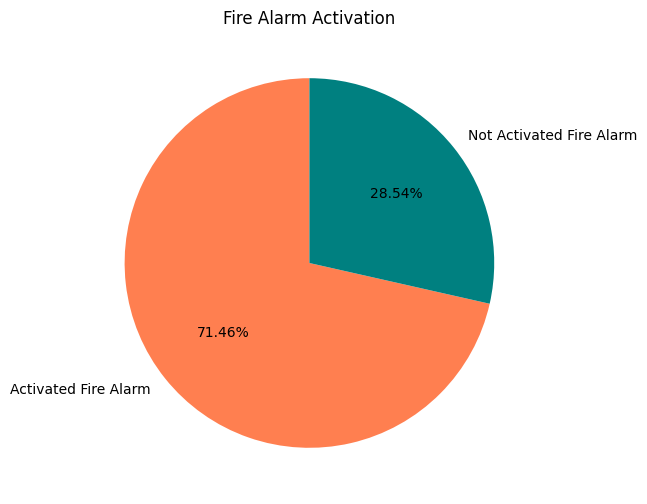

In [63]:
counts = dataset["Fire Alarm"].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=["Activated Fire Alarm", "Not Activated Fire Alarm"], autopct='%1.2f%%', startangle=90, colors=["coral", "teal"])
plt.title("Fire Alarm Activation")
plt.show()

# Data Pre-Processing

Innanzittutto rinominiamo la colonna "Unnamed: 0" con il nome "Id", ovvero l'Id della misurazione rilevata:

In [64]:
dataset = dataset.rename(columns={"Unnamed: 0": "Id"})

Verifichiamo quindi la presenza di duplicati:

In [65]:
f"Duplicated values: {dataset.shape[0] - dataset.duplicated().value_counts()[False]}"

'Duplicated values: 0'

Eliminiamo poi colonne non necessarie all'apprendiamento, ovvero la neo-colonna "Id", "UTC", ovvero il timestamp, ed il counter "CNT", salvando una copia per eventuali utilizzi futuri

In [66]:
old_dataset = dataset.copy()
dataset = dataset.drop(columns=["Id", "UTC", "CNT"])

Ora cerchiamo di comprendere la distribuzione dei dati nel tempo:

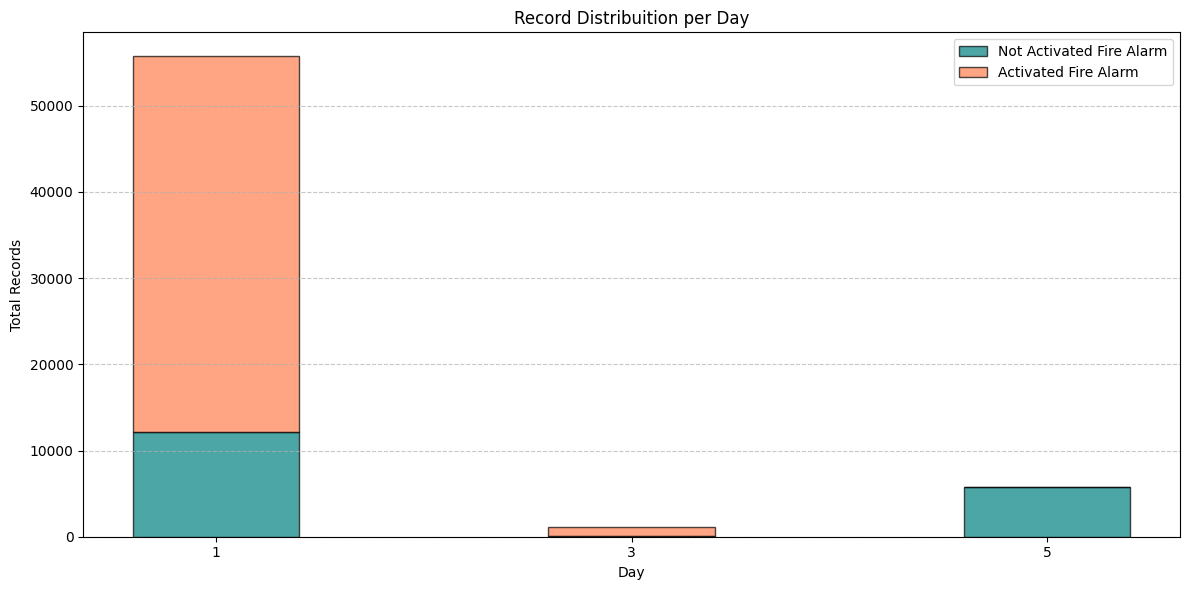

In [67]:
old_dataset["datetime"] = pd.to_datetime(old_dataset["UTC"], unit="s")
old_dataset["day"] = (old_dataset["datetime"] - old_dataset["datetime"].min()).dt.days + 1

day_counts_0 = old_dataset[old_dataset["Fire Alarm"] == 0]["day"].value_counts().sort_index()
day_counts_1 = old_dataset[old_dataset["Fire Alarm"] == 1]["day"].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.bar(day_counts_0.index, day_counts_0.values, color="teal", edgecolor="black", alpha=0.7, label="Not Activated Fire Alarm")
plt.bar(day_counts_1.index, day_counts_1.values, color="coral", edgecolor="black", alpha=0.7, label="Activated Fire Alarm", bottom=day_counts_0.values)
plt.xlabel("Day")
plt.ylabel("Total Records")
plt.title("Record Distribuition per Day")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(day_counts_0.index)
plt.legend()
plt.tight_layout()
plt.show()

Questa distribuzione temporale può influenzare i risultati, poiché sono concentrati in un solo giorno (dove probabilmente si è verificato un incendio). Tuttavia questo non succede, ma anche i dati all'interno della giornata sono diversi (poiché l'allarme antincendio è stato attivato e in altri momenti no).

Notiamo che la distribuzione dei dati è principalmente sul primo giorno, per questo motivo anticipiamo la possibile presenza di dati molto simili, i quali potrebbero influenzare poi la modellizzazione futura. Questo fenomeno è tuttavia mitigato dal fatto che durante quel giorno i dati presentano variazioni, poiché l'allarme antincendio è stato attivato in alcuni momenti e non in altri, introducendo una diversità nei dati raccolti.

## Outliers

Ora vediamo la distribuzione, attraverso istogramma, dei valori per ogni feature del dataset, escludendo "Fire Alarm".<br>Attraverso una visualizzazione grafica cerchiamo di capire la eventuale presenza di outliers:

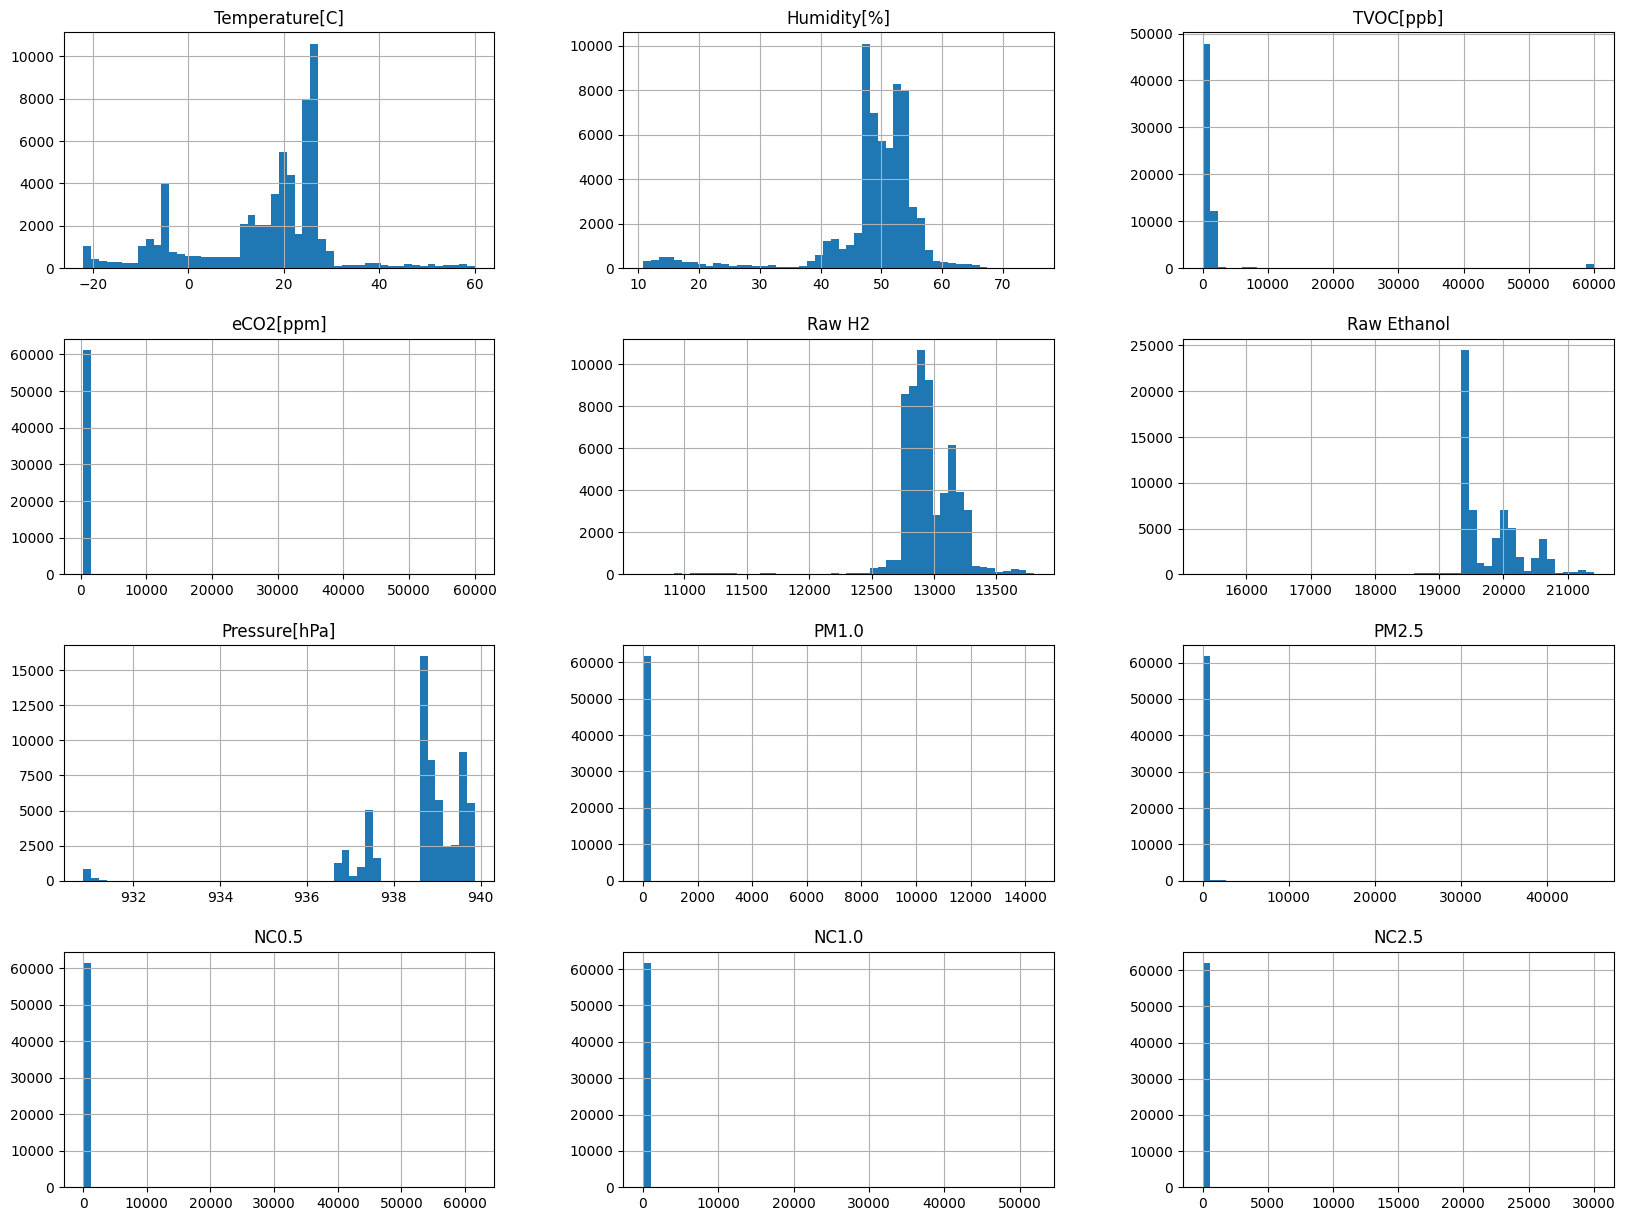

In [68]:
dataset.drop(["Fire Alarm"], axis=1).hist(bins=50, figsize=(20,15))
plt.show()

Notiamo che le possibili colonne con outlier sono: "TVOC[ppb]", "eCO2[ppm]", "Pressure[hPa]", "PM1.0", "PM2.5", "NC0.5", "NC1.0", "NC2.5", in quanto le misurazioni sono maggiormente concentrate in specifici intervalli di valori

In [69]:
outliers_columns = ["TVOC[ppb]", "eCO2[ppm]", "Pressure[hPa]","PM1.0", "PM2.5", "NC0.5", "NC1.0", "NC2.5"]

Ci chiediamo ora, non essendo esperti del dominio, se in effetti tali valori siano effettivamente outlier, dovuti ad esempio a sbagli nella misurazione da parte del sensore, o se essi siano effettivamente valori che assumono valori particolarmente alti o particolarmente bassi a seconda. Per la rilevazione degli outlier useremo lo **z-score**.

### Valutazione ed Eliminazione con **z-score**

Lo z-score misura la distanza di un valore dalla media in unità di deviazione standard.

Dato un valore $x$, una media $\mu$, ed una deviazione standard $\sigma$, si ha:

$z = \frac{x - \mu}{\sigma}$

Dato un valore positivo $n$, si stabilisce che un valore $|z|>n$ è considerato outlier; nel nostro caso $n=3$.

Calcoliamo lo z-score per ogni colonna con possibili outlier nel dataset.

In [70]:
def delete_outliers_z(data, column, threshold = 3):
    remaining_data = data[np.abs(zscore(data[column])) < threshold]
    data.loc[np.abs(zscore(data[column])) > threshold, ("Deleted")] = column
    outliers = data[np.abs(zscore(data[column])) > threshold]
    return remaining_data, outliers

In [71]:
dataset_z_score = dataset.copy()
outliers = pd.DataFrame()

for column in outliers_columns:
    dataset_z_score, out = delete_outliers_z(dataset_z_score, column)
    outliers = pd.concat([outliers, out])
    print(f"Column: {column.ljust(15)} - Found Outliers: {str(out.shape[0]).ljust(7)} - Total Outliers: {outliers.shape[0]}")

Column: TVOC[ppb]       - Found Outliers: 1270    - Total Outliers: 1270
Column: eCO2[ppm]       - Found Outliers: 340     - Total Outliers: 1610
Column: Pressure[hPa]   - Found Outliers: 814     - Total Outliers: 2424
Column: PM1.0           - Found Outliers: 66      - Total Outliers: 2490
Column: PM2.5           - Found Outliers: 32      - Total Outliers: 2522
Column: NC0.5           - Found Outliers: 0       - Total Outliers: 2522
Column: NC1.0           - Found Outliers: 8       - Total Outliers: 2530
Column: NC2.5           - Found Outliers: 152     - Total Outliers: 2682


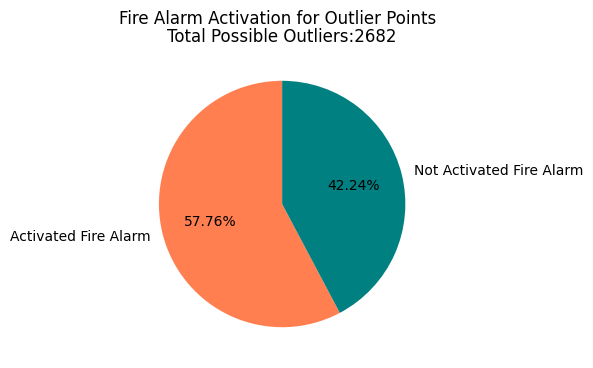

In [72]:
counts = outliers["Fire Alarm"].value_counts()
plt.figure(figsize=(4, 4))
plt.pie(counts, labels=["Activated Fire Alarm", "Not Activated Fire Alarm"], autopct='%1.2f%%', startangle=90, colors=["coral", "teal"])
plt.suptitle("Fire Alarm Activation for Outlier Points")
plt.title(f"Total Possible Outliers:{outliers.shape[0]}")
plt.show()

Osserviamo che, in generale, i possibili outlier non si limitano a identificare semplicemente i punti di attivazione degli allarmi.

Le anomalie sono state riscontrate in quasi tutte le colonne. Procediamo quindi ad analizzare, colonna per colonna, se esistono relazioni significative tra di esse.

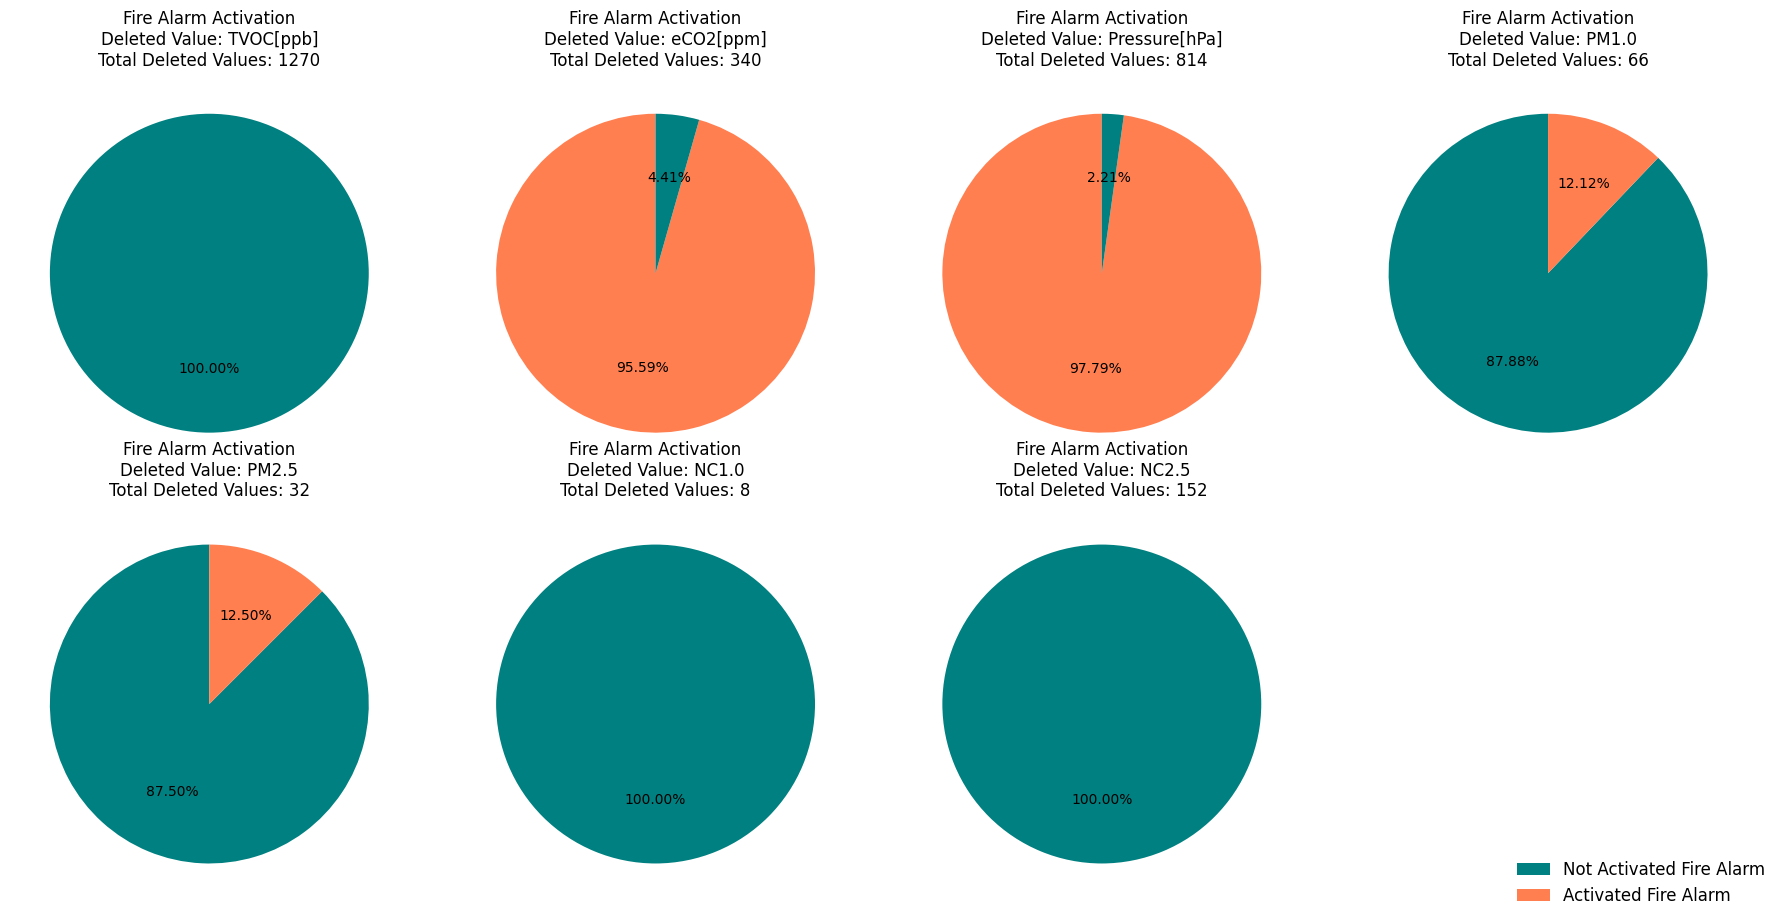

In [73]:
unique_deleted_values = outliers["Deleted"].unique()

fig, axs = plt.subplots(2, 4, figsize=(18, 10))
axs = axs.flatten()

labels = ["Not Activated Fire Alarm", "Activated Fire Alarm"]
color_map = {0: "teal", 1: "coral"}

for i, value in enumerate(unique_deleted_values):
    subset = outliers[outliers["Deleted"] == value]
    counts = subset["Fire Alarm"].value_counts()
    if len(counts) == 1:
        single_value = counts.index[0]
        pie_colors = [color_map[single_value]]
        pie_labels = [labels[single_value]]
    else:
        pie_colors = [color_map[val] for val in counts.index]
        pie_labels = [labels[val] for val in counts.index]
    axs[i].pie(counts, autopct='%1.2f%%', startangle=90, colors=pie_colors)
    axs[i].set_title(f"Fire Alarm Activation\nDeleted Value: {value}\nTotal Deleted Values: {subset.shape[0]}")

for j in range(i + 1, len(axs)):
    axs[j].axis("off")

fig.legend(labels, loc="lower right", ncol=1, frameon=False, fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

Risulta evidente come a questo punto, sia probabile che questi punti non siano outliers, bensì veri e propri indicatori di un possibile allarme.
Ad esempio, per quanto riguarda la pressione, notiamo che i valori bassi che potevano essere identificati come outliers, in realtà hanno una forte correlazione con l'attivazione dell'allarme.
Tale esempio è applicabile anche ai restanti campi. Decidiamo dunque di esplorare la correlazione tra i vari attributi e lo scattare dell'allarme.

## Correlazione tra i dati

In [74]:
def show_fire_alarm_activation_plot(data, column, log_scale=False):

    fire_alarm_0 = data[data["Fire Alarm"] == 0][column]
    fire_alarm_1 = data[data["Fire Alarm"] == 1][column]
    
    bins = np.histogram_bin_edges(data[column], bins=30)
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    bins_0 = axs[0].hist(fire_alarm_0, bins=bins, alpha=0.7, label="Not Activated Fire Alarm", color="teal", edgecolor="black")
    bins_1 = axs[0].hist(fire_alarm_1, bins=bins, alpha=0.7, label="Activated Fire Alarm", color="coral", edgecolor="black")
    axs[0].set_title(f"{column} Values over Fire Alarm Activation")
    axs[0].set_ylabel("Total Fire Alarm Activations")
    axs[0].legend()
    axs[0].grid(axis="y", linestyle="--", alpha=0.7)

    axs[1].hist(fire_alarm_0, bins=bins, alpha=0.7, label="Not Activated Fire Alarm", color="teal", edgecolor="black")
    axs[1].set_title(f"{column} Values over not Activated Fire Alarm")
    axs[1].legend()
    axs[1].grid(axis="y", linestyle="--", alpha=0.7)

    axs[2].hist(fire_alarm_1, bins=bins, alpha=0.7, label="Activated Fire Alarm", color="coral", edgecolor="black")
    axs[2].set_title(f"{column} Values over Activated Fire Alarm")
    axs[2].legend()
    axs[2].grid(axis="y", linestyle="--", alpha=0.7)

    if log_scale:
        for ax in axs:
            ax.set_yscale("log")

    plt.tight_layout()
    plt.show()

### Temperatura

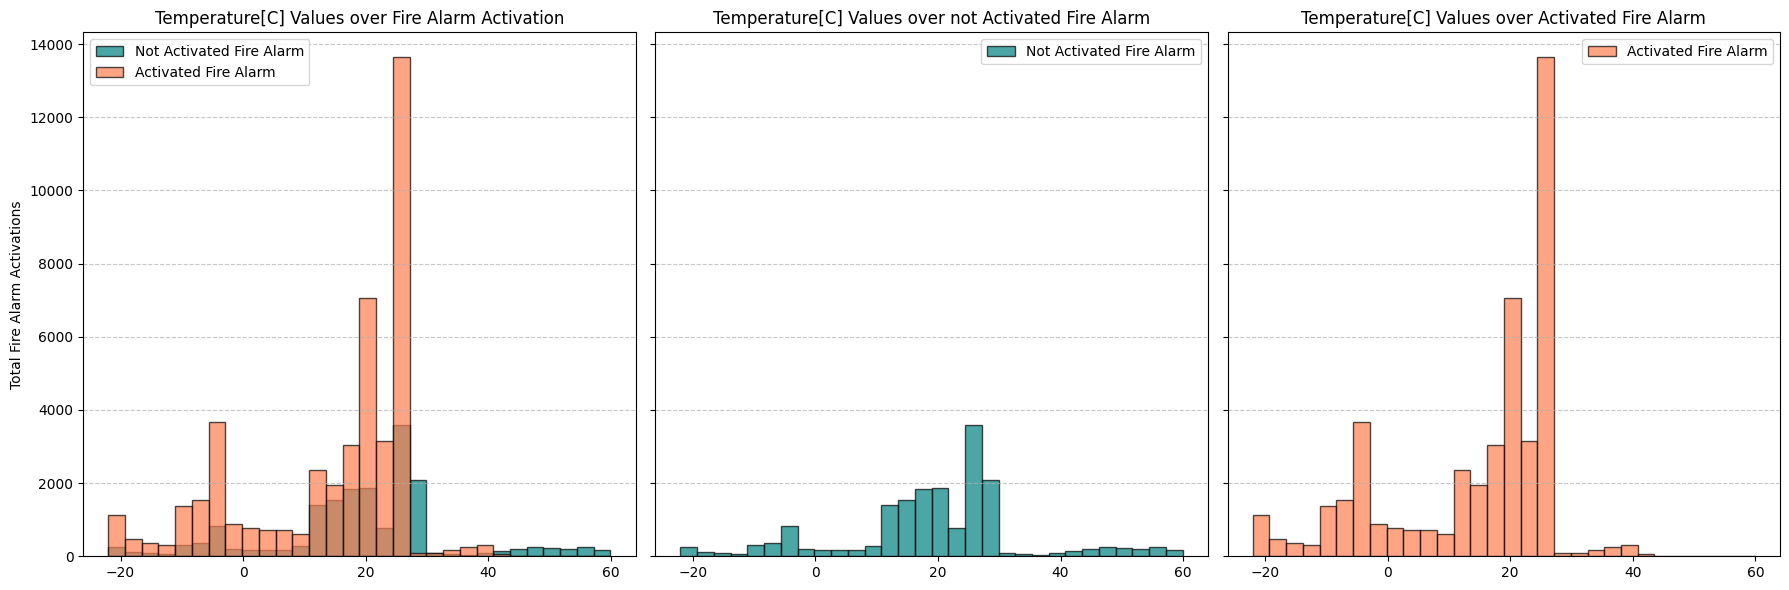

In [75]:
show_fire_alarm_activation_plot(dataset, "Temperature[C]")

### Humidity

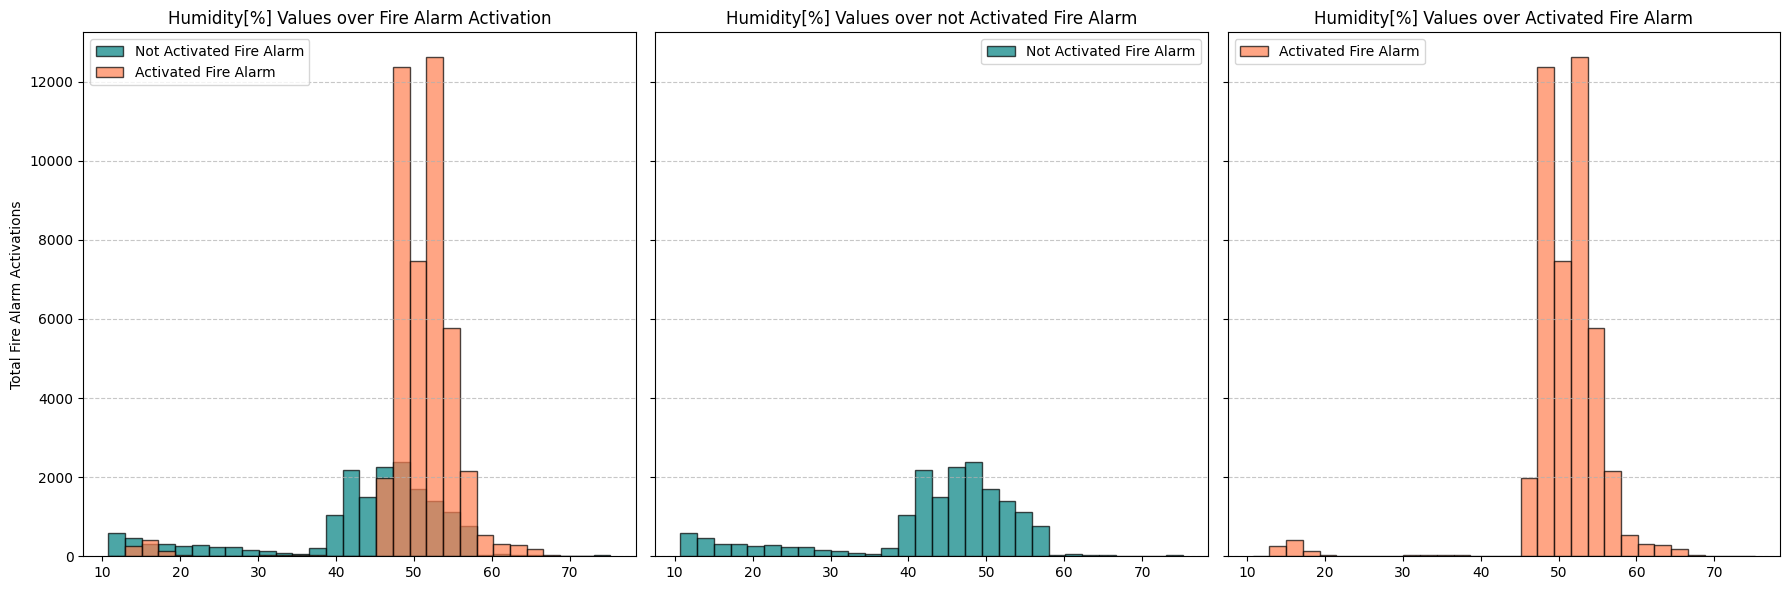

In [76]:
show_fire_alarm_activation_plot(dataset, "Humidity[%]")

### TVOC

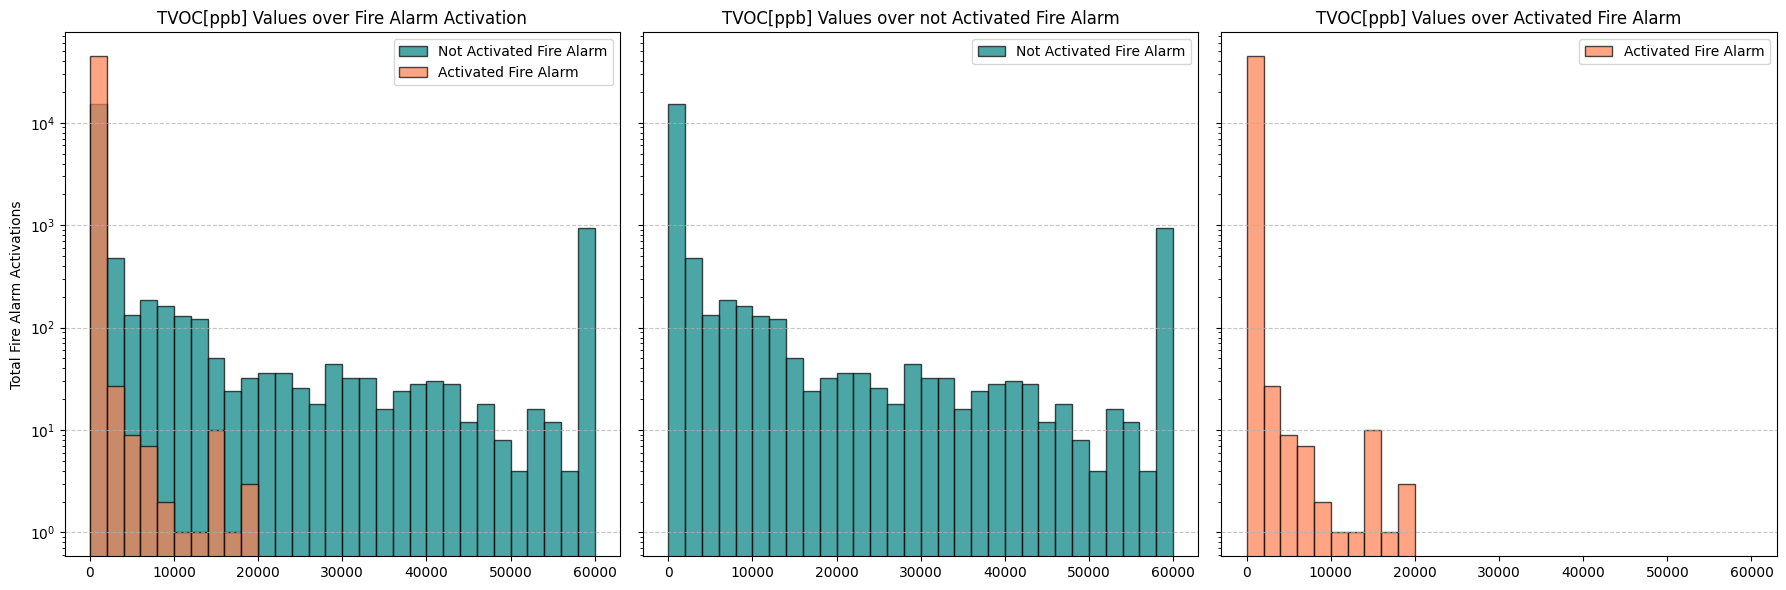

In [77]:
show_fire_alarm_activation_plot(dataset, "TVOC[ppb]", log_scale=True)

Si noti che questo ed alcuni dei grafici successivi, sull'asse $y$ presentano una scala logaritmica in quanto, se pur i valori sull'asse $x$ siano distribuiti abbastanza linearmente (nel caso `TVOC`: $0 \le \text{TVOC} \le 60000 $), sull'asse y si ha che i valori più alti sono a ridosso di $x \approx 0$; con un a scala lineare, rimarrebbero in vista solo tali valori a scapito degli altri.
Con questa scala riusciamo ad evidenziare meglio i valori lungo tutto l'asse x; si noti però che comunque la maggior parte dei record del dataset hanno, in questo caso, un $\text{TVOC} \le 2000$, a discapito di quanto si possa pensare da una prima occhiata sommaria al grafico, infatti:

In [78]:
low_TVOC_values = dataset.loc[dataset["TVOC[ppb]"] <= 2000, "TVOC[ppb]"].shape[0]
low_TVOC_percentage = np.round(low_TVOC_values / dataset.shape[0] * 100, 2)
print(f"TVOC values below 2000: {low_TVOC_values}\nPercentage: {low_TVOC_percentage}%")

TVOC values below 2000: 59899
Percentage: 95.64%


Tale osservazione è estendibile ad altri grafici con scala logaritmica

### eCO2

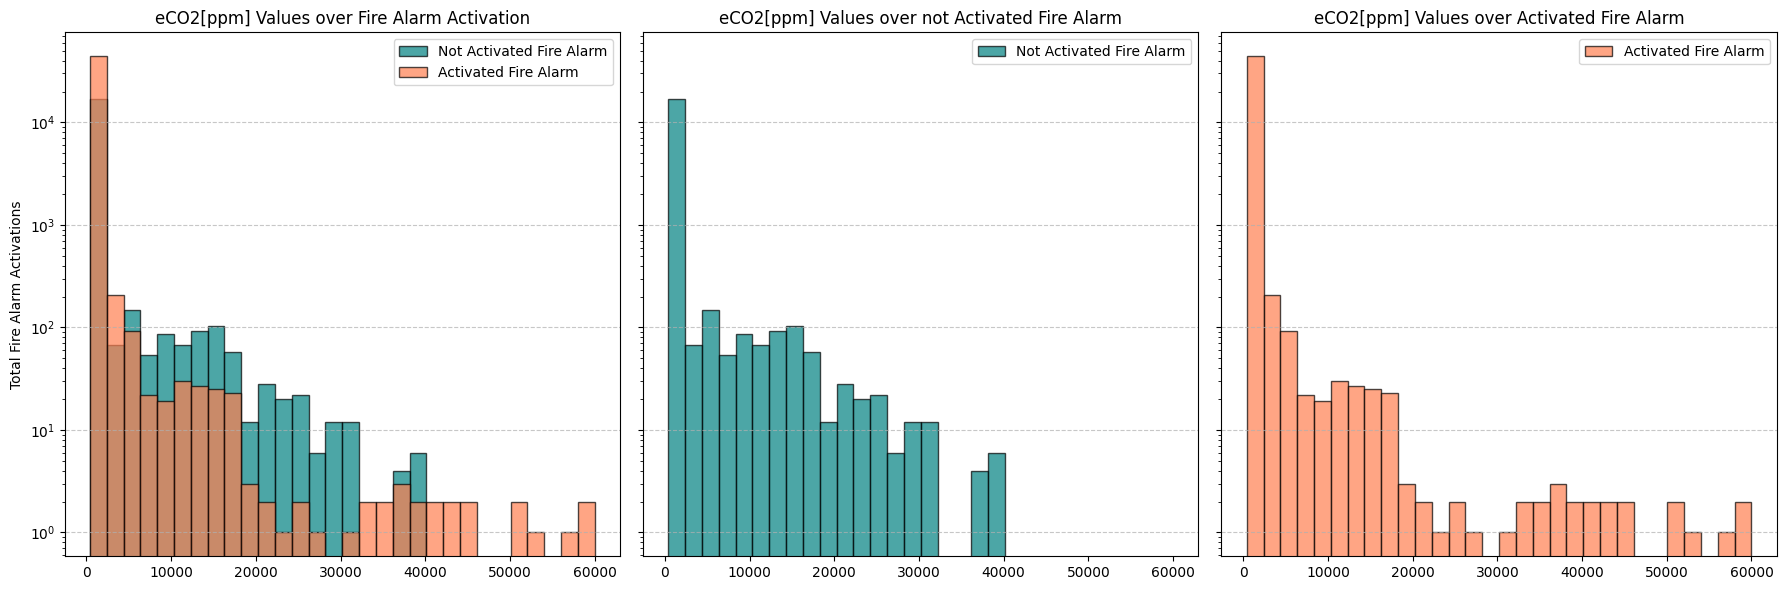

In [79]:
show_fire_alarm_activation_plot(dataset, "eCO2[ppm]", log_scale=True)

### Raw H2

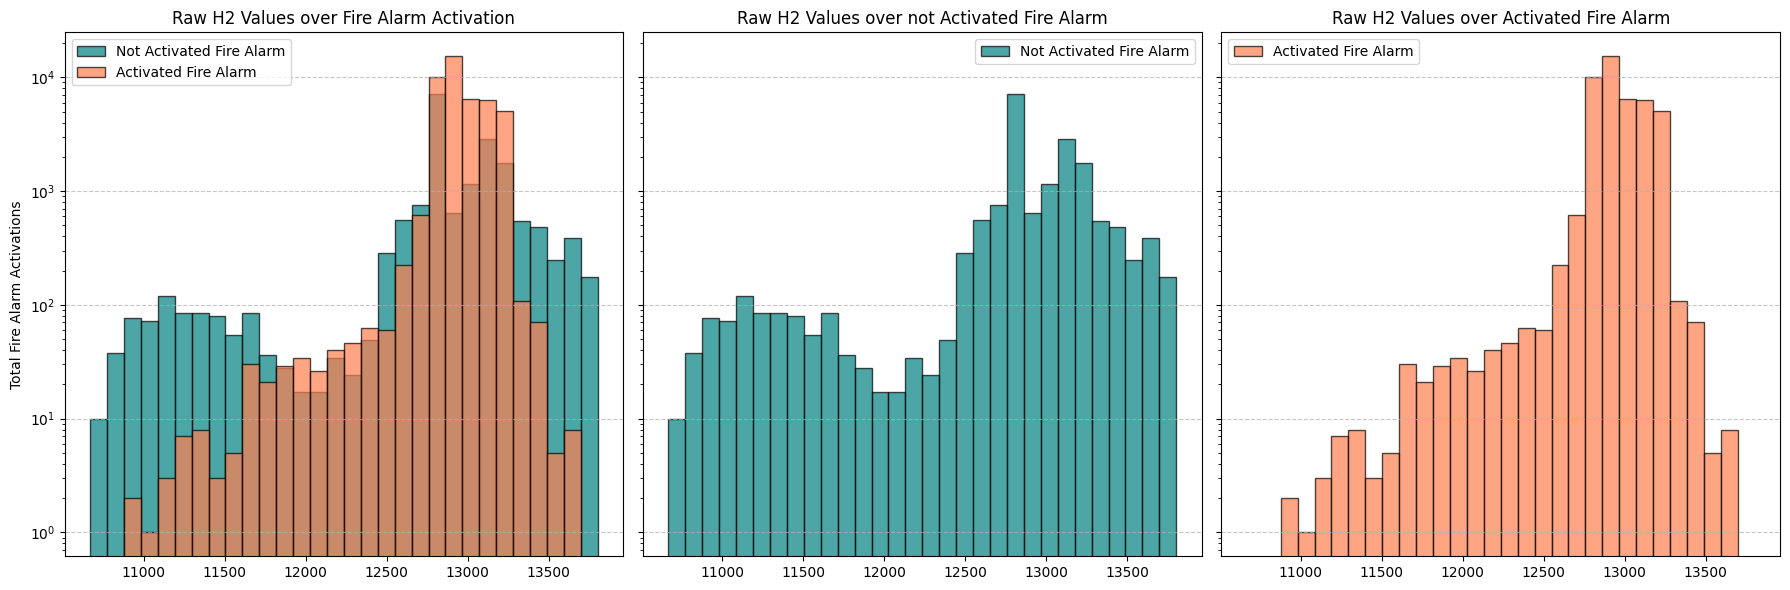

In [80]:
show_fire_alarm_activation_plot(dataset, "Raw H2", log_scale=True)

### Raw Ethanol

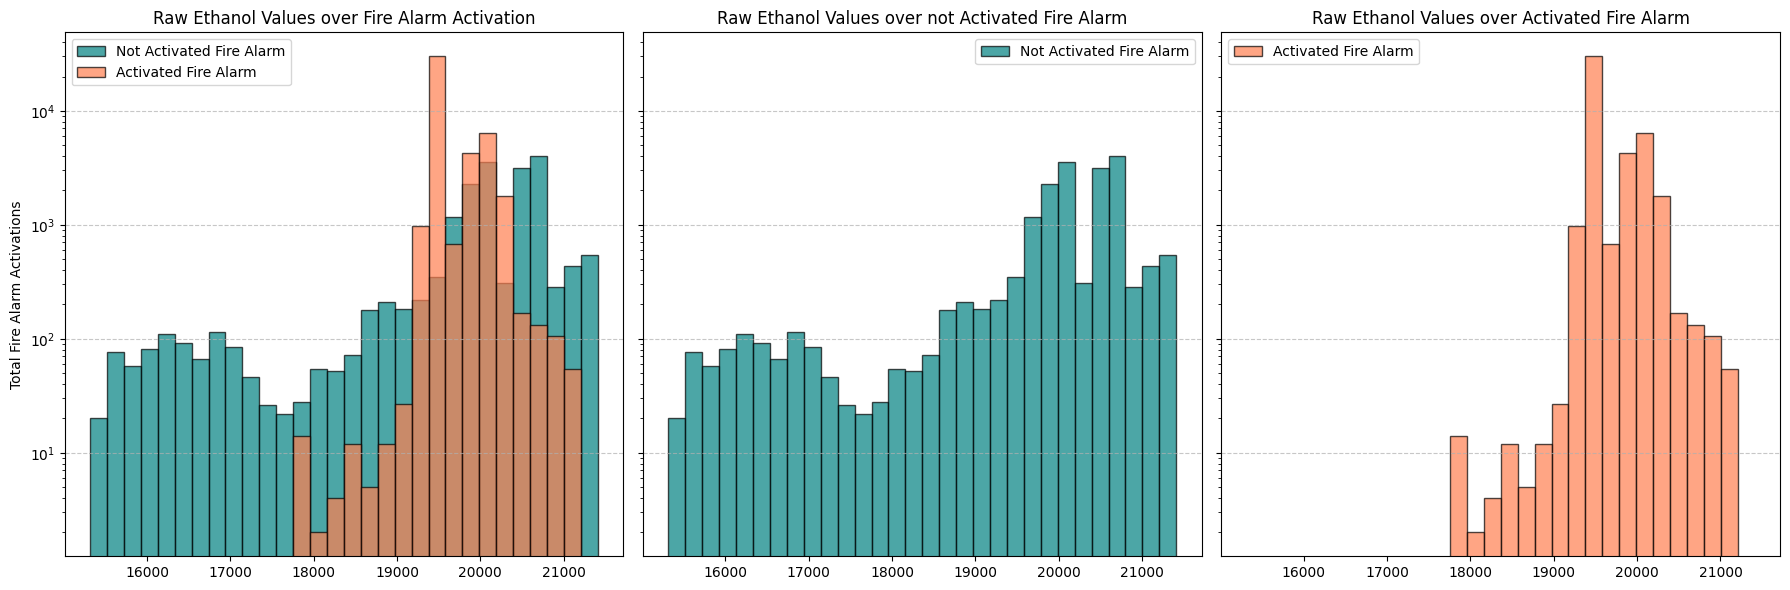

In [81]:
show_fire_alarm_activation_plot(dataset, "Raw Ethanol", log_scale=True)

### Pressure[hPa]

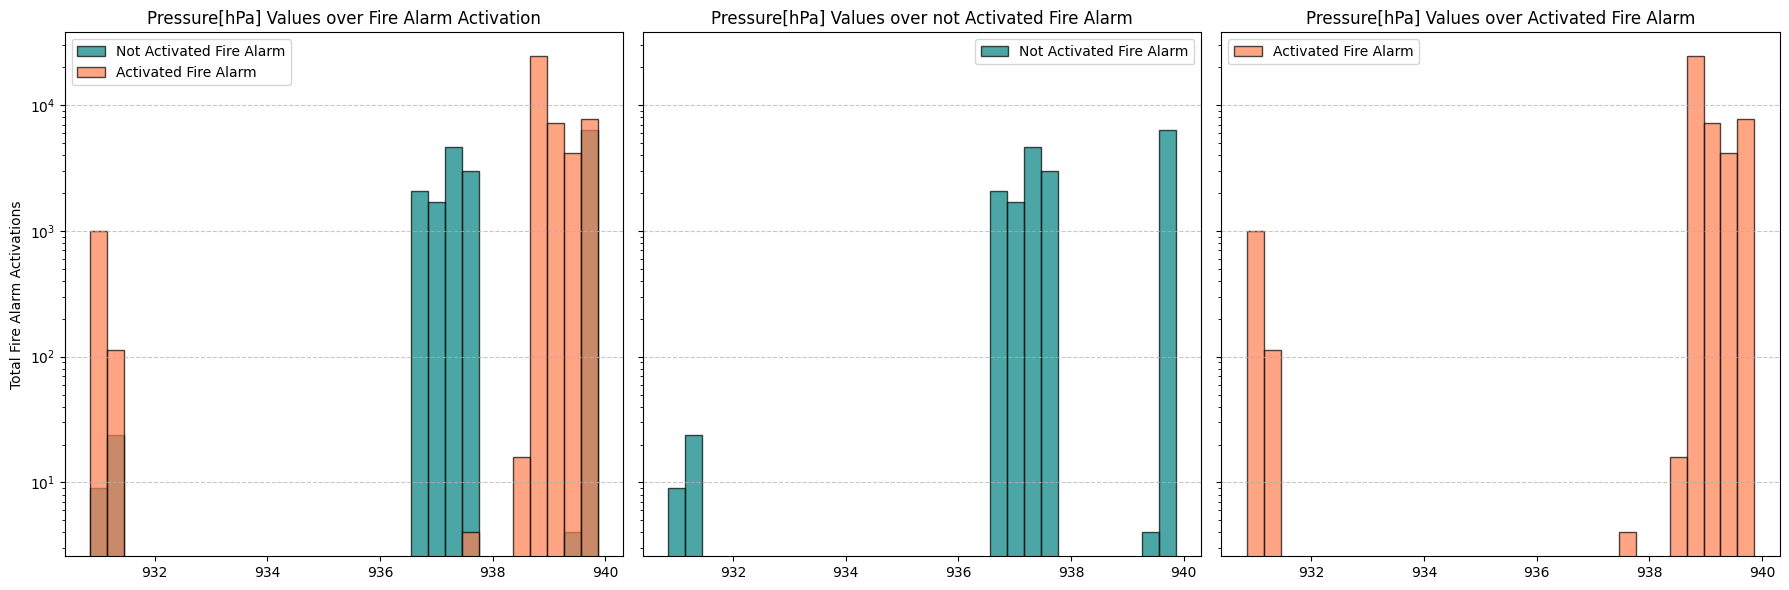

In [82]:
show_fire_alarm_activation_plot(dataset, "Pressure[hPa]", log_scale=True)

Contrariamente ad altri valori, la pressione indica, già graficamente, una netta separazione tra alcuni dei valori che attivano la soglia di allarme.
Ad esempio, data una pressione $p$, si ha (sommariamente) che:

$p \le 932 \implies \text{Fire Alarm} = 1$

$936 \le p \le 938 \implies \text{Fire Alarm} = 0$

$p > 938 \implies \text{Fire Alarm} = 1$

In generale, è probabile che la pressione sia un buon indicatore per la target feature.

### PM1.0

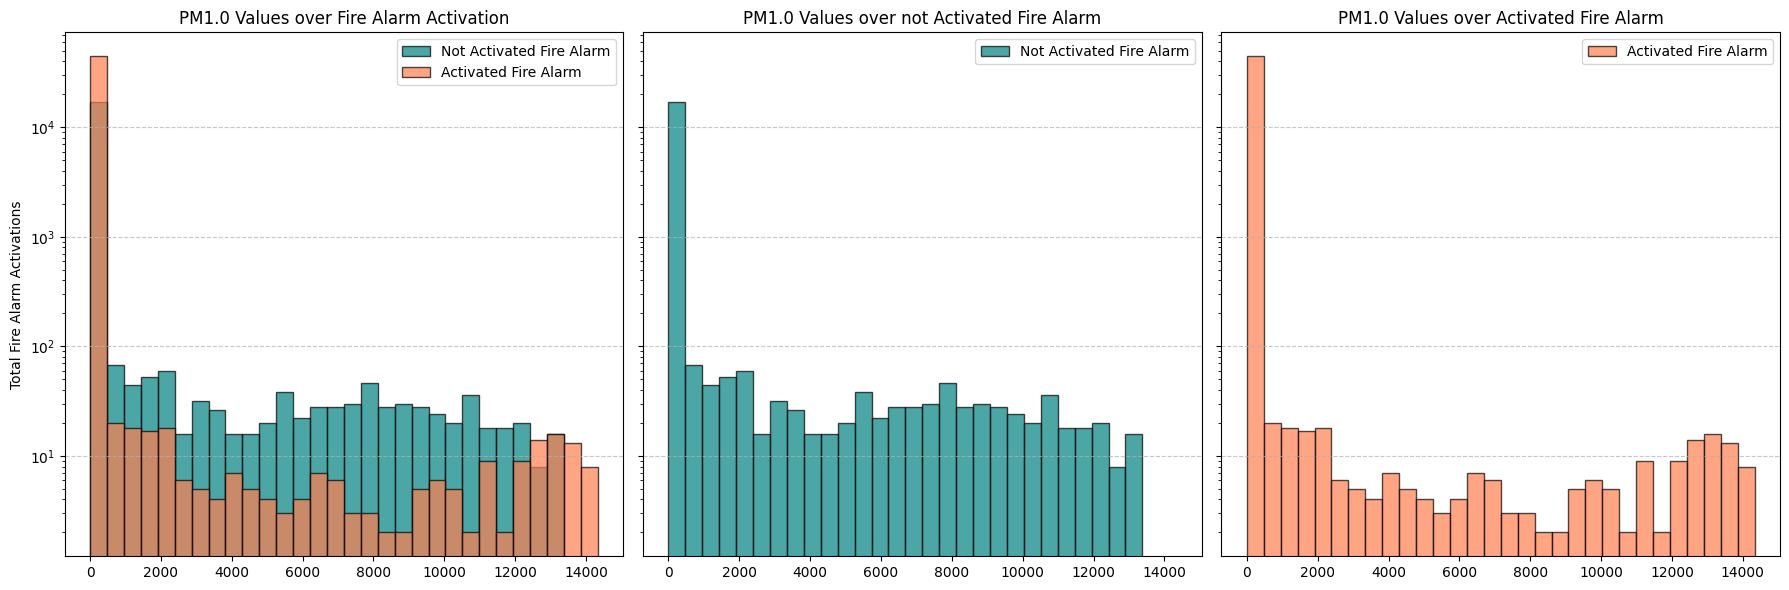

In [83]:
show_fire_alarm_activation_plot(dataset, "PM1.0", log_scale=True)

### PM2.5

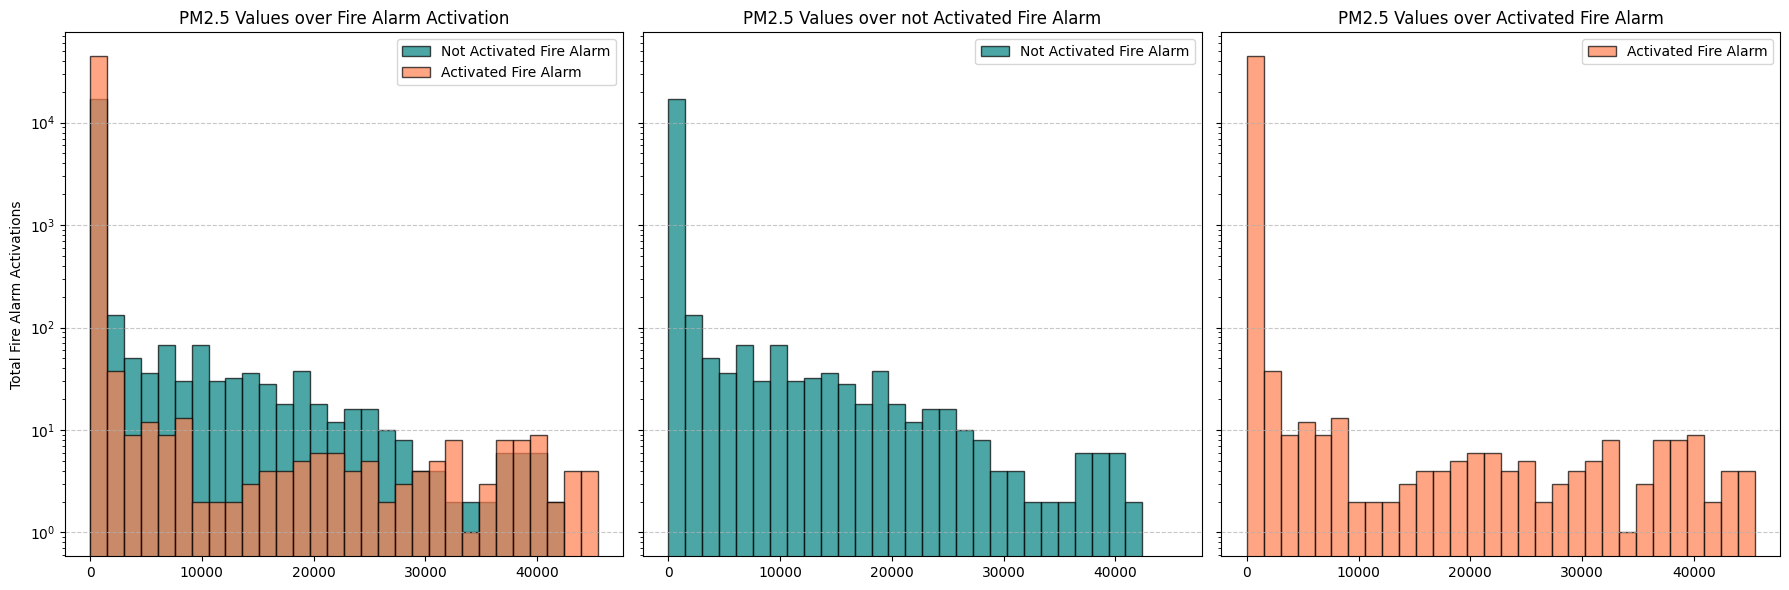

In [84]:
show_fire_alarm_activation_plot(dataset, "PM2.5", log_scale=True)

### NC0.5

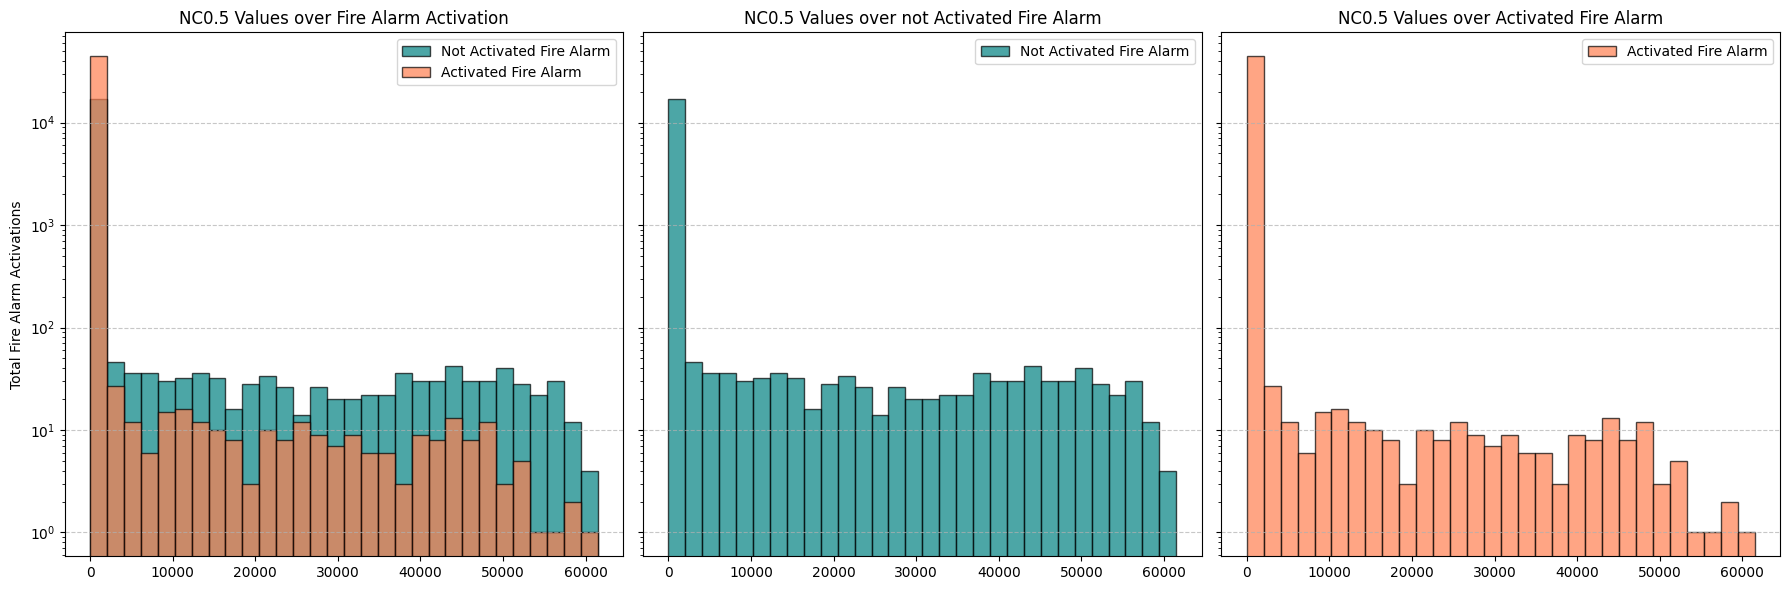

In [85]:
show_fire_alarm_activation_plot(dataset, "NC0.5", log_scale=True)

### NC1.0

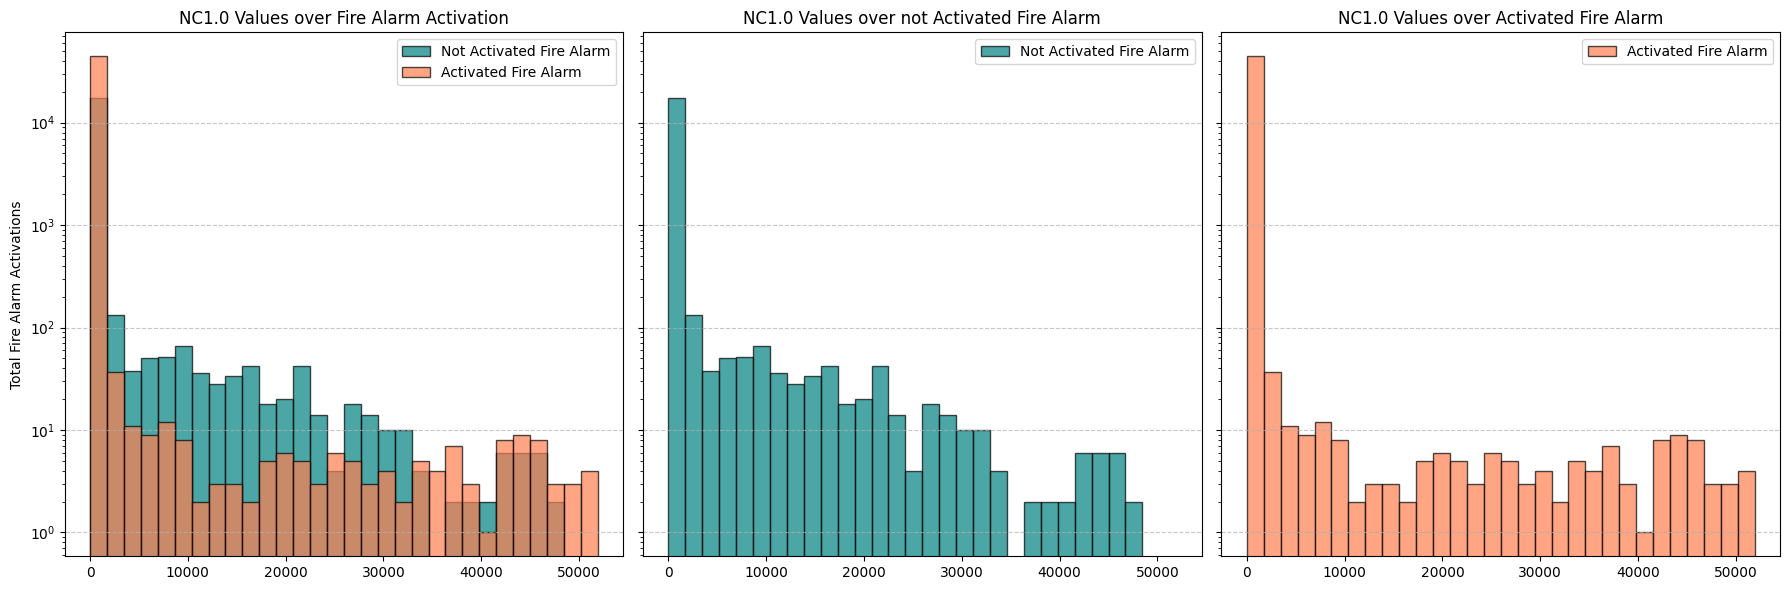

In [86]:
show_fire_alarm_activation_plot(dataset, "NC1.0", log_scale=True)

### NC2.5

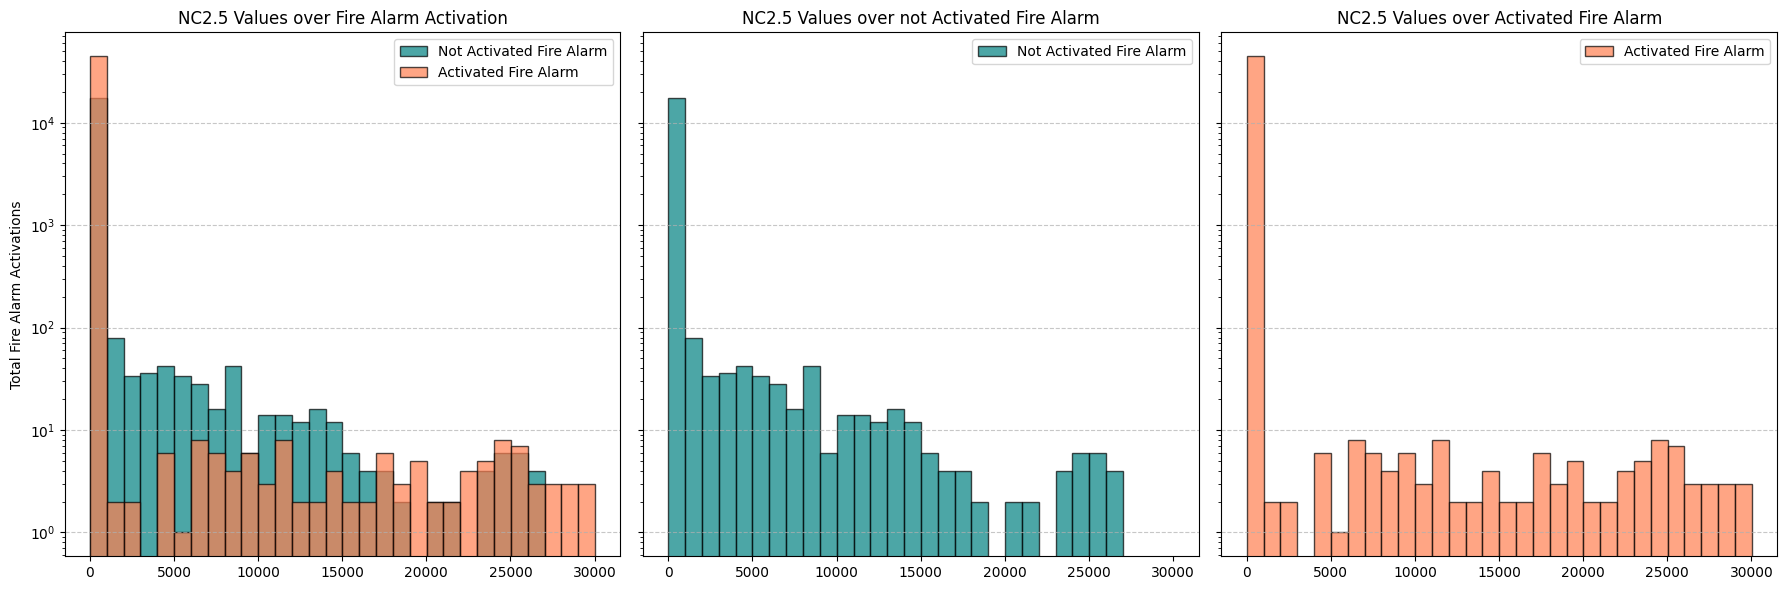

In [87]:
show_fire_alarm_activation_plot(dataset, "NC2.5", log_scale=True)

### Correlation Matrix

Visti ora i grafici che rapportano le varie feature alla target feature, cerchiamo di calcolare una correlazione tra di essere e soprattutto con la target feature, così da capire se alcune di queste sono particolarmente significative:

In [88]:
correlation = dataset.corr()
correlation

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm
Temperature[C],1.000000,-0.243986,0.082442,0.079265,-0.135540,-0.037343,-0.251203,0.037330,0.032084,0.039291,0.031608,0.025526,-0.163902
Humidity[%],-0.243986,1.000000,-0.488878,-0.369095,0.247199,0.068782,0.694614,-0.236538,-0.178882,-0.277389,-0.174224,-0.118502,0.399846
TVOC[ppb],0.082442,-0.488878,1.000000,0.606118,-0.653053,-0.673715,-0.220004,0.597366,0.477424,0.670657,0.467386,0.344721,-0.214743
eCO2[ppm],0.079265,-0.369095,0.606118,1.000000,-0.682785,-0.506695,-0.326043,0.665482,0.572691,0.699604,0.564252,0.456323,-0.097006
Raw H2,-0.135540,0.247199,-0.653053,-0.682785,1.000000,0.631495,0.303090,-0.530714,-0.431079,-0.587769,-0.422626,-0.318518,0.107007
Raw Ethanol,-0.037343,0.068782,-0.673715,-0.506695,0.631495,1.000000,-0.075926,-0.480698,-0.393192,-0.529186,-0.385720,-0.293351,-0.340652
Pressure[hPa],-0.251203,0.694614,-0.220004,-0.326043,0.303090,-0.075926,1.000000,-0.258938,-0.243071,-0.248657,-0.241148,-0.213390,0.249797
PM1.0,0.037330,-0.236538,0.597366,0.665482,-0.530714,-0.480698,-0.258938,1.000000,0.956118,0.940045,0.949860,0.854901,-0.110552
PM2.5,0.032084,-0.178882,0.477424,0.572691,-0.431079,-0.393192,-0.243071,0.956118,1.000000,0.798873,0.999787,0.969382,-0.084916
NC0.5,0.039291,-0.277389,0.670657,0.699604,-0.587769,-0.529186,-0.248657,0.940045,0.798873,1.000000,0.786274,0.626711,-0.128118


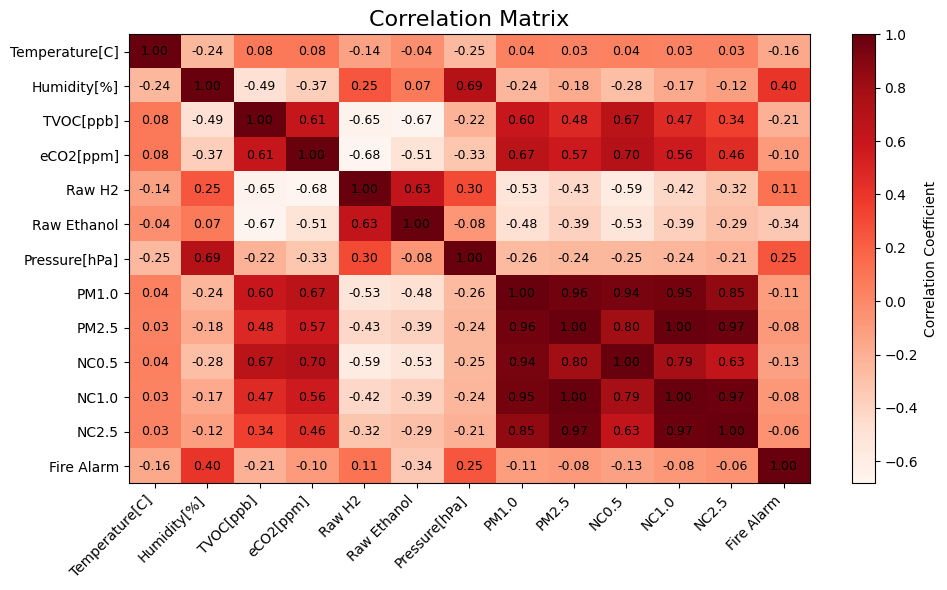

In [89]:
plt.figure(figsize=(10, 6))
plt.imshow(correlation, cmap="Reds", interpolation="none", aspect="auto")
plt.colorbar(label="Correlation Coefficient")

plt.xticks(ticks=np.arange(len(correlation.columns)), labels=correlation.columns, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(correlation.columns)), labels=correlation.columns)

for i in range(len(correlation.columns)):
    for j in range(len(correlation.columns)):
        plt.text(i, j, f"{correlation.iloc[i, j]:.2f}", ha="center", va="center", color="black", fontsize=9)

plt.title("Correlation Matrix", fontsize=16)

plt.tight_layout()
plt.show()

Considerando come alta una correlazione con indice superiore a 0,7, notiamo che tutti i dati del tipo **NC\*** e **PM\*** risultano fortemente correlati tra loro. Questo avviene perché si riferiscono alla concentrazione di particelle simili, ma con spessori diversi: ad esempio, le particelle **PM2.5** saranno generalmente presenti in un numero simile, ma leggermente maggiore rispetto alle particelle **PM1.0**, che appartengono allo stesso tipo ma hanno un diametro inferiore.

In generale, tuttavia, non emergono valori di correlazione particolarmente significativi tra le diverse feature e quella target.

## Data Split

Dividiamo il dataset a nostra disposizione come sempre in tre parti, una per il training, una per la validation, una per il testing, dando rispettivamente il 60%, il 20% ed il 20% di parte del dataset.

In [90]:
random_seed = 42

train_ratio = 0.60
test_ratio = 0.20
validation_ratio = 0.20

x_data = dataset.drop("Fire Alarm", axis=1)
y_data = dataset["Fire Alarm"]

x_train_val, x_test, y_train_val, y_test = train_test_split(x_data, y_data, test_size=test_ratio, random_state=random_seed)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=validation_ratio/(train_ratio+validation_ratio), random_state=random_seed)


Verifichiamo poi che la distribuzione della classe target si mantenga simile nelle diverse porzioni di dataset riservate:

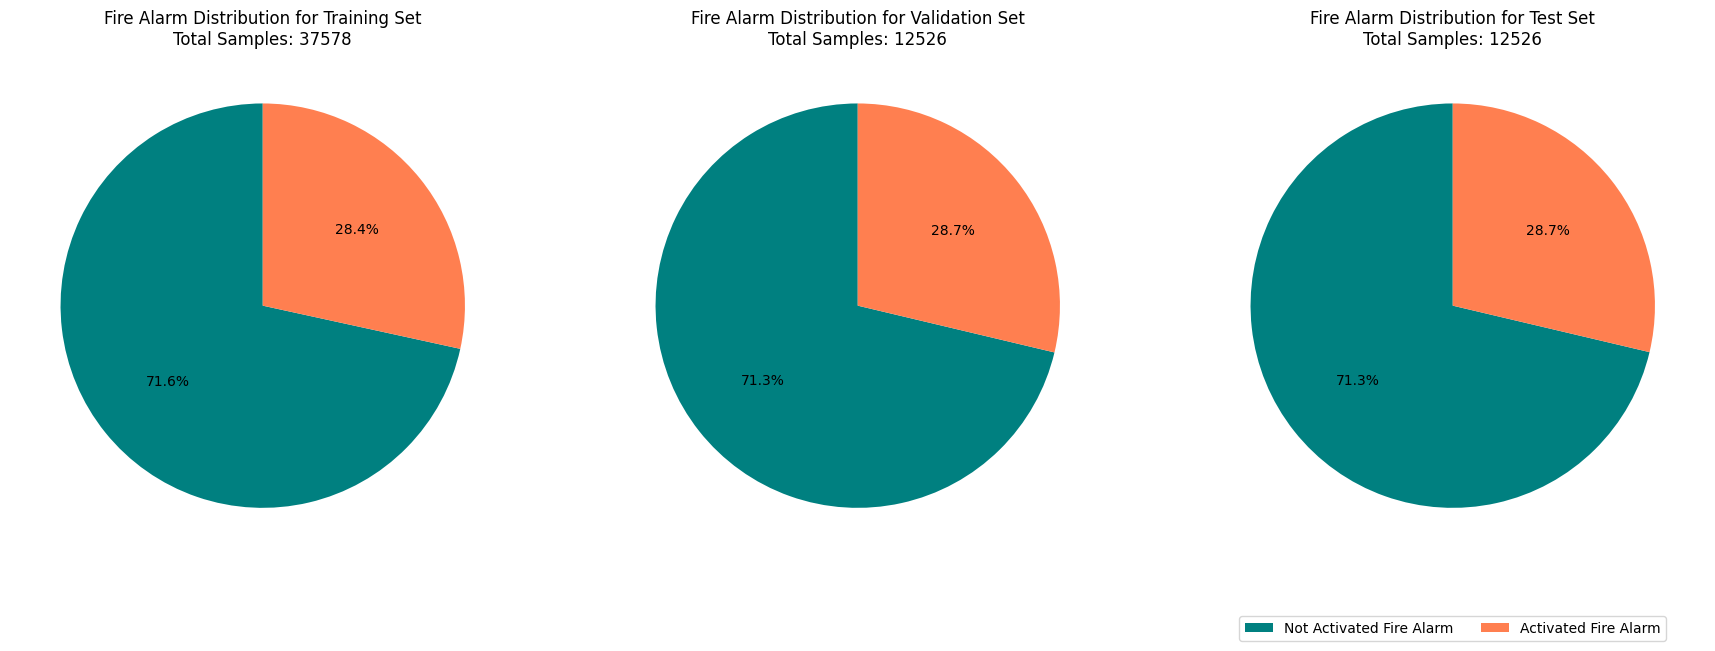

In [91]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
counts = y_train.value_counts()
axs[0].pie(counts, autopct='%1.1f%%', startangle=90, colors=["teal", "coral"])
axs[0].set_title(f"Fire Alarm Distribution for Training Set\nTotal Samples: {len(y_train)}")

counts = y_val.value_counts()
axs[1].pie(counts, autopct='%1.1f%%', startangle=90, colors=["teal", "coral"])
axs[1].set_title(f"Fire Alarm Distribution for Validation Set\nTotal Samples: {len(y_val)}")

counts = y_test.value_counts()
axs[2].pie(counts, autopct='%1.1f%%', startangle=90, colors=["teal", "coral"])
axs[2].set_title(f"Fire Alarm Distribution for Test Set\nTotal Samples: {len(y_test)}")

plt.legend(labels=["Not Activated Fire Alarm", "Activated Fire Alarm"], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

plt.tight_layout()
plt.show()

# Model Creation

Testiamo diversi modelli sui dati tenendo conto del tempo e dell'accuratezza di ognuno.
Per tenere traccia dei vari risultati creiamo una classe in cui metteremo le varie informazioni dei modelli

In [92]:
class Model():
    model: sk.base.BaseEstimator = None
    train_time: float = None
    accuracy: float = None
    prediction_time: float = None
    # additional information that change from model to model
    add_info: dict = None

    def __init__(self, model: sk.base.BaseEstimator):
        self.model = model
        
    def __name__(self):
        return self.model.__class__.__name__
    
    def __str__(self):
        print(f"Model: {self.model.__class__.__name__}")
        print(f"Accuracy: {self.accuracy*100:.2f}%")
        print(f"Training Time: {self.train_time:.6f} seconds")
        print(f"Prediction Time: {self.prediction_time:.6f} seconds")
        if self.add_info:
            for key, value in self.add_info.items():
                print(f"{key}: {value}")
    
models = {}

## Dummy Classifier

Il primo classificatore è un Dummy Classifier, ovvero un classificatore che non tiene conto delle feature in input.

In [93]:

dummy_model = DummyClassifier(random_state=random_seed)
model = Model(dummy_model)
models[model.__name__()] = model

# training
start = time.time()
dummy_model.fit(x_train, y_train)
elapsed = time.time() - start
models[model.__name__()].train_time = elapsed

# prediction
start = time.time()
prediction = dummy_model.predict(x_test)
elapsed = time.time() - start
models[model.__name__()].prediction_time = elapsed

# accuracy
models[model.__name__()].accuracy = accuracy_score(y_test, prediction)

unique, frequency = np.unique(prediction, return_counts = True)
models[model.__name__()].add_info = {"Unique Values": unique, "Frequency": frequency}

models[model.__name__()].__str__()

Model: DummyClassifier
Accuracy: 71.31%
Training Time: 0.001518 seconds
Prediction Time: 0.000463 seconds
Unique Values: [1]
Frequency: [12526]


Utilizziamo la strategia di default `prior`: il metodo di predizione ritorna sempre la label di maggior frequenza tra i valori `y` osservati. Ne consegue che avremo un output fisso ad 1, ovvero il valore di maggiore frequenza, e l'accuracy sarà uguale alla presenza di 1 nel test set, ovvero circa il 71%.

## Decision Tree Classifier

Ora applichiamo un semplice Decision Tree Classifier: non imponiamo alcun valore specifico per gli iperparametri, ma utilizziamo semplicemente quelli di default (_gini_ per l'impurità e _best_ come criterio di split) ed un random seed per garantire la riproducibilità. (utilizzato anche nei modelli successivi)

Successivamente, se sarà necessario, regoleremo alcuni di questi variando gli iperparametri.

In [99]:
decision_tree_model = DecisionTreeClassifier(random_state=random_seed)

model = Model(decision_tree_model)
models[model.__name__()] = model

# training
start = time.time()
decision_tree_model.fit(x_train, y_train)
elapsed = time.time() - start
models[model.__name__()].train_time = elapsed

# prediction
start = time.time()
prediction = decision_tree_model.predict(x_test)
elapsed = time.time() - start
models[model.__name__()].prediction_time = elapsed

# accuracy
default_tree_accuracy = accuracy_score(y_test, prediction)
models[model.__name__()].accuracy = default_tree_accuracy

# additional information
default_tree_max_depth = decision_tree_model.get_depth()
default_tree_nodes = decision_tree_model.get_n_leaves()

models[model.__name__()].add_info = {"Max Depth": default_tree_max_depth, "Number of Nodes": default_tree_nodes}

models[model.__name__()].__str__()

Model: DecisionTreeClassifier
Accuracy: 99.97%
Training Time: 0.119725 seconds
Prediction Time: 0.001933 seconds
Max Depth: 8
Number of Nodes: 28


Vediamo ora una rappresentazione grafica dell'albero generato dall'algoritmo:

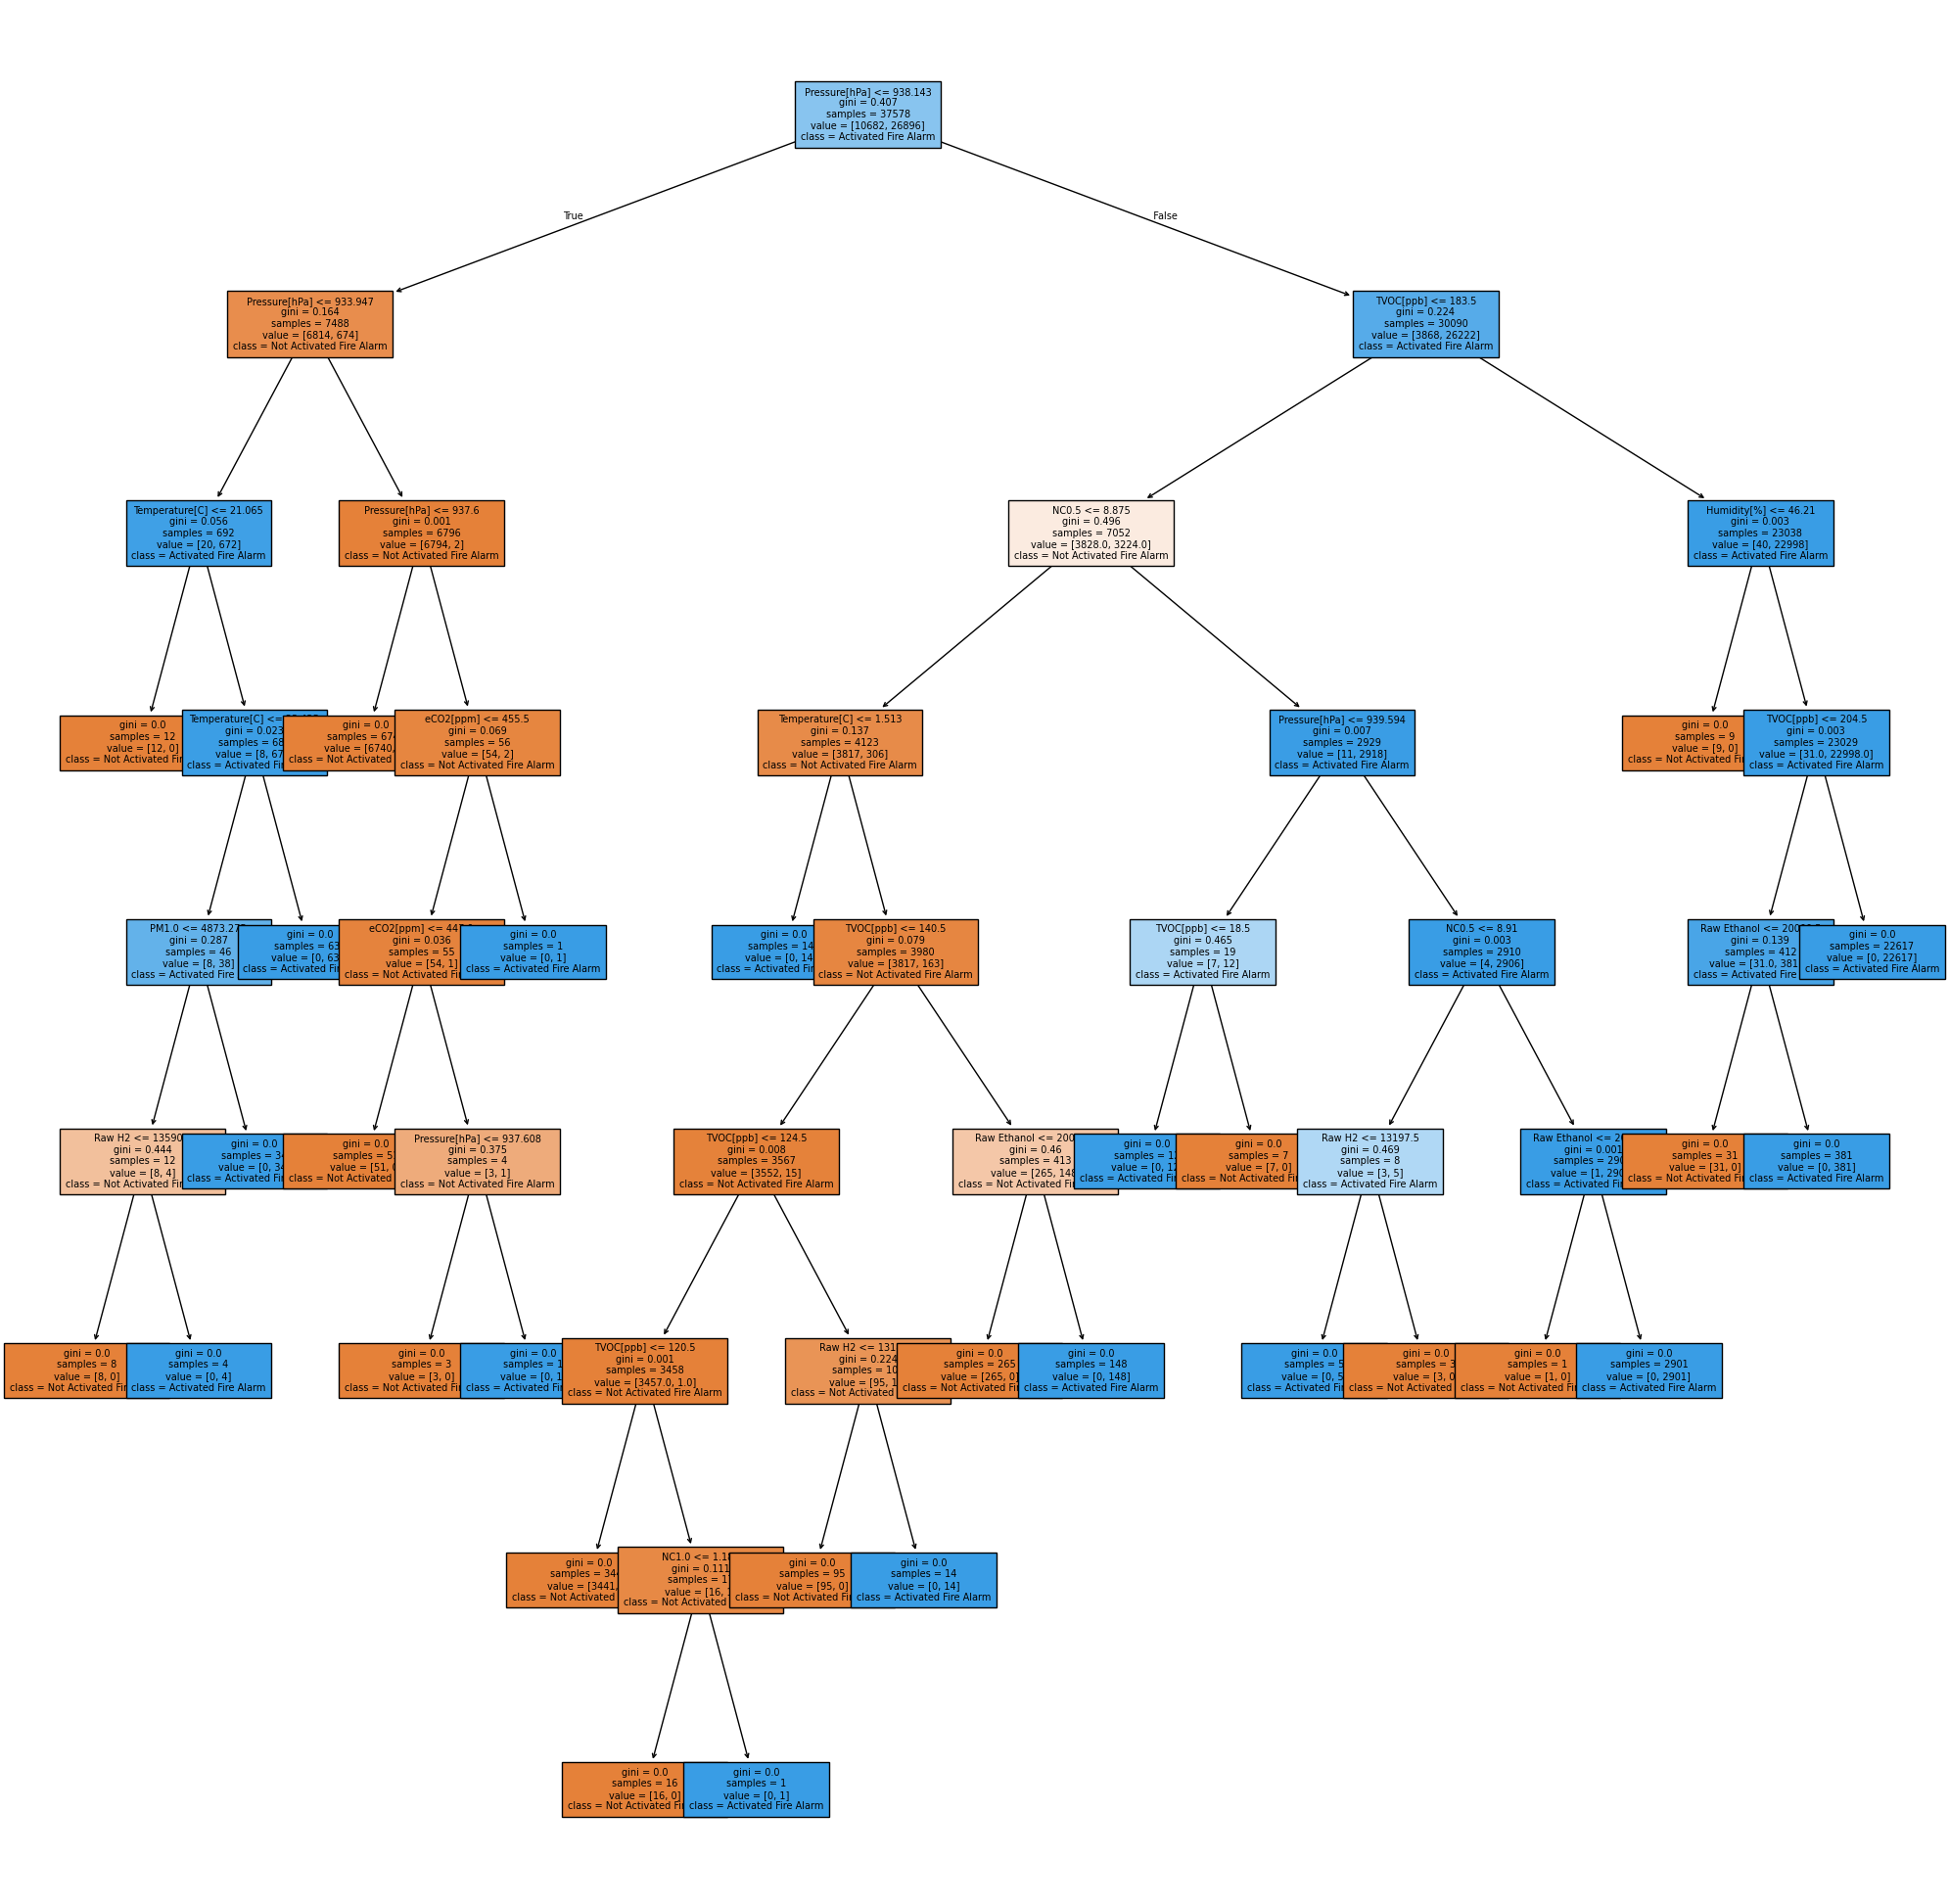

In [101]:
plt.figure(figsize=(25, 25))
sk.tree.plot_tree(decision_tree_model, filled=True, feature_names=x_data.columns, class_names=["Not Activated Fire Alarm", "Activated Fire Alarm"], fontsize=7)
plt.show()

from sklearn.tree import export_graphviz
import graphviz

dot_data = sk.tree.export_graphviz(
    decision_tree_model,
    out_file=None,
    filled=True,
    feature_names=x_data.columns,
    class_names=["Not Activated Fire Alarm", "Activated Fire Alarm"]
)

graph = graphviz.Source(dot_data)
graph.render("decision_tree", format="png");

Come già accennato, il valore della pressione può rappresentare una caratteristica particolarmente utile per effettuare la suddivisione. Infatti, osservando l'albero, notiamo che il nodo radice si divide al valore di 938.143, come evidenziato in precedenza durante l'analisi.

Mostriamo, quindi, di seguito l'importanza di ogni caratteristica all'interno del modello Decision Tree, espressa in valore percentuale.

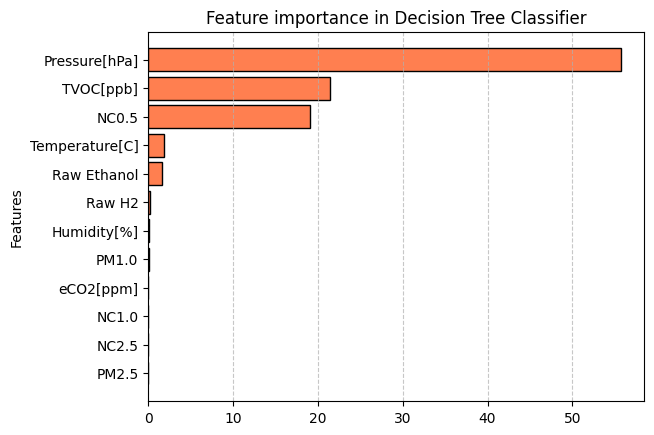

In [102]:
feature_importance_association = sorted(list(zip(x_train.columns, decision_tree_model.feature_importances_*100.0)), key=lambda x: x[1])
feature_importance_plot_x = [feature_name for feature_name, _ in feature_importance_association]
feature_importance_plot_y = [importance for _, importance in feature_importance_association]
plt.barh(feature_importance_plot_x, feature_importance_plot_y, color="coral", edgecolor="black")
plt.ylabel("Feature Importance [%]")
plt.ylabel("Features")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.title("Feature importance in Decision Tree Classifier")
plt.show()

Il decision tree modellato ha un alto valore di accuracy.

Questo risultato è probabilmente influenzato dalla distribuzione del dataset. Come spiegato precedentemente i dati sono concentrati principalmente in un solo giorno.
Inoltre non abbiamo alcuna presenza di outliers.

I dati hanno quindi un pattern ben definito e omogeneo ed è visibile una chiara separabilità tra le classi che viene identificata egregiamente da Decision Tree.

### Maximum Depth

Ora, come visto a lezione, proviamo a variare il numero di nodi dell'albero, aumentando la sua profondità massima. Cerchiamo di verificare se l'accuratezza del training set e del validation set stanno divergendo oppure no.

In [103]:
train_results = []
val_results = []

depths = list(range(1, default_tree_max_depth))
nodes = []

for depth in depths:
    classifier = DecisionTreeClassifier(max_depth=depth, random_state=random_seed)
    classifier.fit(x_train, y_train)

    train_tree_prediction = classifier.predict(x_train)
    accuracy_training = accuracy_score(y_train, train_tree_prediction)
    train_results.append(accuracy_training)

    y_val_prediction = classifier.predict(x_val)
    accuracy_val = accuracy_score(y_val, y_val_prediction)
    val_results.append(accuracy_val)
    nodes.append(classifier.get_n_leaves())


Visualizziamo graficamente

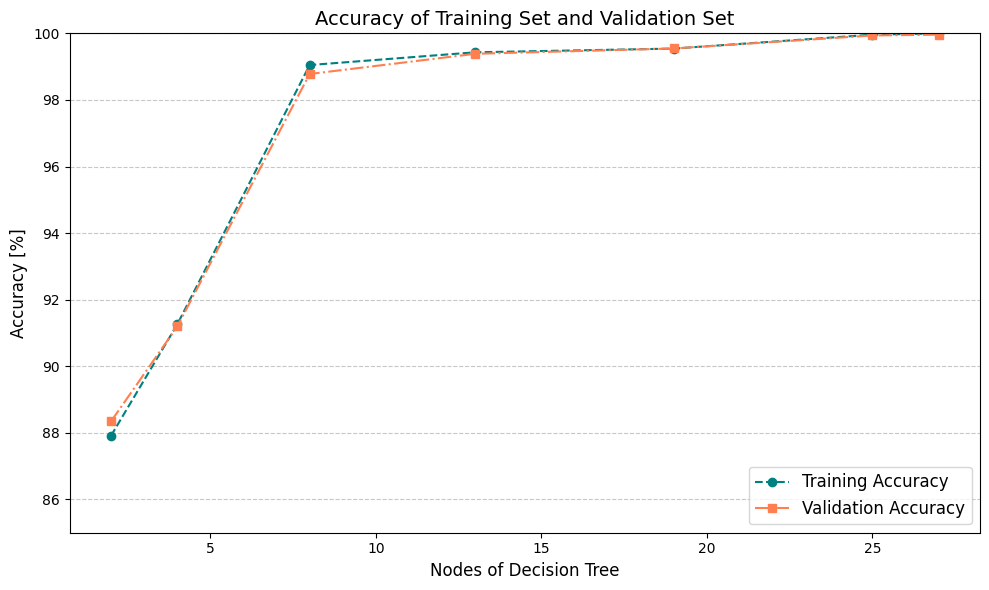

In [105]:
plt.figure(figsize=(10, 6))
plt.plot(nodes, np.array(train_results) * 100, label="Training Accuracy", color="teal", marker="o", linestyle="--")
plt.plot(nodes, np.array(val_results) * 100, label="Validation Accuracy", color="coral", marker="s", linestyle="-.")

plt.xlabel("Nodes of Decision Tree", fontsize=12)
plt.ylabel("Accuracy [%]", fontsize=12)
plt.ylim(85, 100)  
# plt.xticks(depths)

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(loc="lower right", fontsize=12)
plt.title("Accuracy of Training Set and Validation Set", fontsize=14)

plt.tight_layout()
plt.show()


Spesso l'accuracy del validation set diverge da quella del training set (fenomemo di **overfitting**)

In questo caso il dataset è semplice e la distribuzione è omogenea (probabilmente a cauda della distribuzione temporale). Il Decision Tree generalizza bene su entrambi i set, considerando che non abbiamo rumore e outliers significanti.

Il risultato finale è che il training set e il validation set tendono al 100% di accuracy.

## Random Forest Classifier

Utilizziamo ora la random forest e verifichiamo se randomizzando le features ottiamo risultati differenti.

In [113]:
random_forest_model = RandomForestClassifier(random_state=random_seed)
model = Model(random_forest_model)
models[model.__name__()] = model

# training
start = time.time()
random_forest_model.fit(x_train_val, y_train_val)
elapsed = time.time() - start
models[model.__name__()].train_time = elapsed

# prediction
start = time.time()
random_forest_prediction = random_forest_model.predict(x_test)
elapsed = time.time() - start
models[model.__name__()].prediction_time = elapsed

# accuracy
random_forest_accuracy = accuracy_score(y_test, random_forest_prediction)
models[model.__name__()].accuracy = random_forest_accuracy

# additional information
random_forest_estimators = random_forest_model.n_estimators

models[model.__name__()].add_info = {"Number of Estimators": random_forest_estimators}

models[model.__name__()].__str__()

Model: RandomForestClassifier
Accuracy: 100.00%
Training Time: 4.210231 seconds
Prediction Time: 0.035805 seconds
Number of Estimators: 100


Proviamo a variare il numero di estimator diminuendoli e verificando se diminuisce anche l'accuracy

In [114]:
estimators = list(range(10, 91, 10))
accuracy = []

for total_estimators in estimators:
    random_forest = RandomForestClassifier(n_estimators=total_estimators, random_state=random_seed)
    random_forest.fit(x_train_val, y_train_val)
    predictions = random_forest.predict(x_test)
    acc = accuracy_score(y_test, predictions)
    accuracy.append(acc)

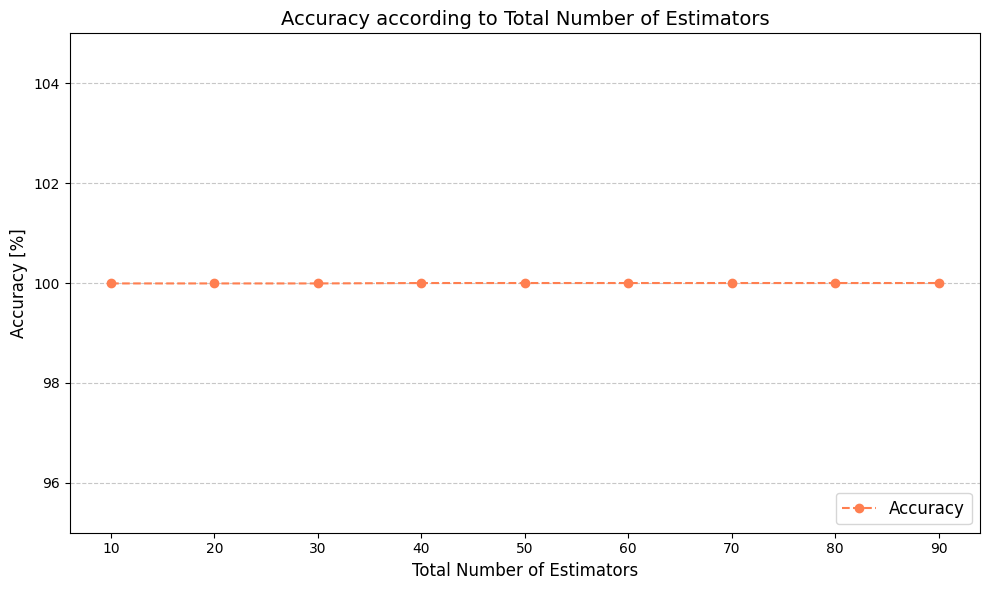

In [115]:
plt.figure(figsize=(10, 6))
plt.plot(estimators, np.array(accuracy) * 100, color="coral", marker="o", linestyle="--", label="Accuracy")

plt.xlabel("Total Number of Estimators", fontsize=12)
plt.ylabel("Accuracy [%]", fontsize=12)
plt.xticks(estimators)
plt.ylim(95, 105)

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(loc="lower right", fontsize=12)
plt.title("Accuracy according to Total Number of Estimators", fontsize=14)

plt.tight_layout()
plt.show()


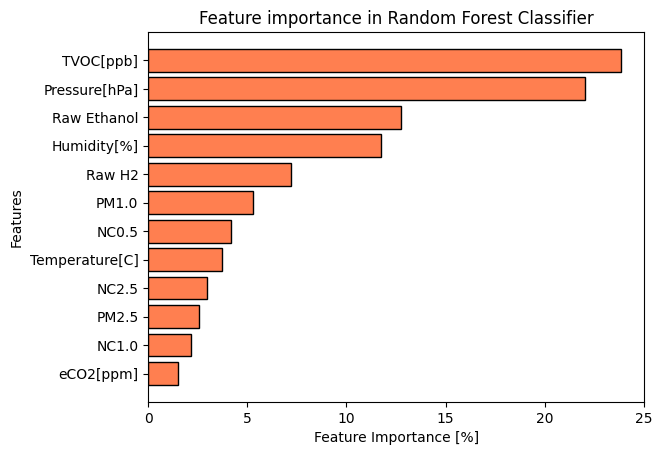

In [116]:
# for name, score in zip(x_train.columns, random_forest_model.feature_importances_):
#     print(f"{name.ljust(20)} - {score*100:.2f}%")

# sort the features by importance
feature_importance_association = sorted(list(zip(x_train.columns, random_forest_model.feature_importances_*100.0)), key=lambda x: x[1])
feature_importance_plot_x = [feature_name for feature_name, _ in feature_importance_association]
feature_importance_plot_y = [importance for _, importance in feature_importance_association]
plt.barh(feature_importance_plot_x, feature_importance_plot_y, color="coral", edgecolor="black")
plt.xlabel("Feature Importance [%]")
plt.ylabel("Features")
plt.title("Feature importance in Random Forest Classifier")
plt.show()

Notiamo che i valori nel grafico sono diversi rispetto a quelli restituiti dal __Decision Tree__.

Una Random Forest è infatti un insieme di alberi decisionali costruiti su sottoinsiemi casuali dei dati e delle feature.

Ogni albero considera solo un sottoinsieme delle feature a ogni split, riducendo il rischio che una sola feature dominante influenzi il modello. Questo porta a una distribuzione più equilibrata dell'importanza tra le feature.
La feature importance in una Random Forest è calcolata come la media delle importanze assegnate a ciascuna feature dai singoli alberi. Questa media riduce la varianza, ma può "diluire" l'importanza di feature fortemente influenti in singoli alberi.

I __Decision Tree__ tendono a favorire feature con una forte correlazione con il target, inoltre, poiché non c'è campionamento casuale, l'albero è deterministico e le importanze delle feature dipendono interamente dalla struttura dell'albero ottimizzato sui dati di training.

## Bagging Classifier

Il __Bagging Classifier__ è simile alle random forest, tuttavia non fa sampling delle features.
Testiamo quindi la sua bontà:

In [117]:
bagging_model = BaggingClassifier(random_state=random_seed)
model = Model(bagging_model)

models[model.__name__()] = model

# training
start = time.time()
bagging_model.fit(x_train_val, y_train_val)
elapsed = time.time() - start
models[model.__name__()].train_time = elapsed

# prediction
start = time.time()
bagging_prediction = bagging_model.predict(x_test)
elapsed = time.time() - start
models[model.__name__()].prediction_time = elapsed

# accuracy
bagging_accuracy = accuracy_score(y_test, bagging_prediction)
models[model.__name__()].accuracy = bagging_accuracy

# additional information
bagging_estimators = bagging_model.n_estimators

models[model.__name__()].add_info = {"Number of Estimators": bagging_estimators}

models[model.__name__()].__str__()

Model: BaggingClassifier
Accuracy: 99.98%
Training Time: 1.351474 seconds
Prediction Time: 0.011523 seconds
Number of Estimators: 10


Arrivati a questo punto, notiamo che per il nostro dataset, avere un diverso numero di estimators non influenza la classificazione finale del modello e la sua accuratezza. Ci concentriamo quindi sulla feature importance.

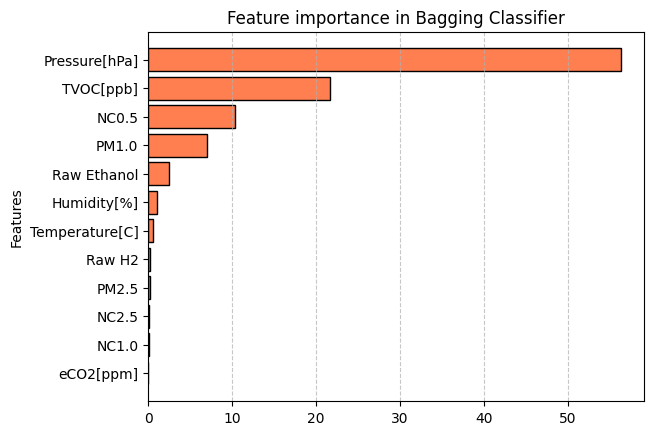

In [118]:
feature_importance = np.zeros(bagging_model.n_features_in_)
for estimator in bagging_model.estimators_:
    feature_importance += estimator.feature_importances_
feature_importance /= bagging_estimators

# sort the feature importance
feature_importance_association = sorted(list(zip(x_train.columns, feature_importance*100.0)), key=lambda x: x[1])

feature_importance_plot_x = [feature_name for feature_name, _ in feature_importance_association]
feature_importance_plot_y = [importance for _, importance in feature_importance_association]

plt.barh(feature_importance_plot_x, feature_importance_plot_y, color="coral", edgecolor="black")
plt.ylabel("Feature Importance [%]")
plt.ylabel("Features")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.title("Feature importance in Bagging Classifier")
plt.show()

Notiamo che è molto simile al [Decision Tree](#decision-tree-classifier). Le motivazioni sono riconducibili al fatto che il Bagging Classifier non fa feature selection ed è composto da decision tree, quindi, nel nostro caso si avvicina molto al risultato del singolo albero decisionale.

## Boosting

Testiamo ora il boosting, il quale migliora iterativamente la performance di un modello combinando più modelli deboli (solitamente deboli classificatori o regressori) per formare un forte predittore. L'idea centrale è correggere gli errori commessi dai modelli precedenti, assegnando più peso ai campioni che sono stati classificati in modo errato.

valutiamo se questo modello porta a risultati diversi dai precedenti utilizzando il modello AdaBoost

In [120]:
adaboost_model = AdaBoostClassifier(random_state=random_seed, algorithm="SAMME")

model = Model(adaboost_model)
models[model.__name__()] = model

# training
start = time.time()
adaboost_model.fit(x_train, y_train)
elapsed = time.time() - start
models[model.__name__()].train_time = elapsed

# prediction
start = time.time()
adaboost_prediction = adaboost_model.predict(x_test)
elapsed = time.time() - start
models[model.__name__()].prediction_time = elapsed

# accuracy
adaboost_accuracy = accuracy_score(y_test, adaboost_prediction)
models[model.__name__()].accuracy = adaboost_accuracy

# additional information
adaboost_estimators = adaboost_model.n_estimators
models[model.__name__()].add_info = {"Number of Estimators": adaboost_estimators}

models[model.__name__()].__str__()

Model: AdaBoostClassifier
Accuracy: 99.72%
Training Time: 1.669083 seconds
Prediction Time: 0.024556 seconds
Number of Estimators: 50


Anche Adaboost, come il [Bagging](#bagging-classifier) non fa sampling delle feature, quindi abbiamo dei valori di feature importance simili a quelli precedenti

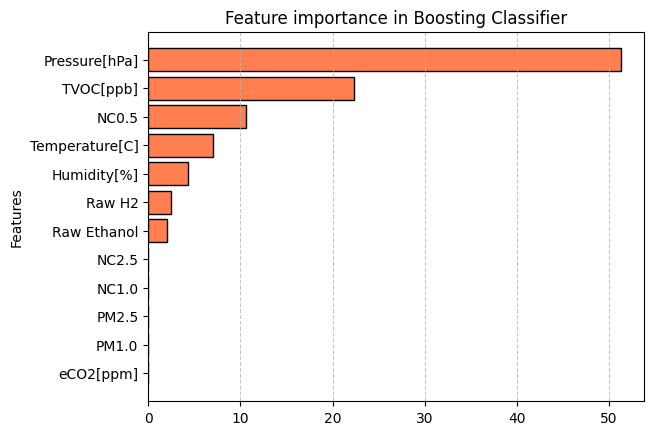

In [76]:
feature_importance_association = sorted(list(zip(x_train.columns, adaboost_model.feature_importances_*100.0)), key=lambda x: x[1])
feature_importance_plot_x = [feature_name for feature_name, _ in feature_importance_association]
feature_importance_plot_y = [importance for _, importance in feature_importance_association]

plt.barh(feature_importance_plot_x, feature_importance_plot_y, color="coral", edgecolor="black")
plt.ylabel("Feature Importance [%]")
plt.ylabel("Features")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.title("Feature importance in Boosting Classifier")
plt.show()

# Support Vector Machine

Testiamo ora le performance utilizzando SVM. Verifichiamo se la separabilità delle feature trovata tramite i metodi precedenti(alberi decisionali) è attuabile attraverso gli iperpiani separatori utilizzati da SVM (che, in particolari casi di binary classification, possono essere efficienti)

In [123]:
linear_svc_model = LinearSVC(random_state=random_seed)

model = Model(linear_svc_model)
models[model.__name__()] = model

# training
start = time.time()
linear_svc_model.fit(x_train, y_train)
elapsed = time.time() - start
models[model.__name__()].train_time = elapsed

# prediction
start = time.time()
linear_svc_prediction = linear_svc_model.predict(x_test)
elapsed = time.time() - start
models[model.__name__()].prediction_time = elapsed

# accuracy
linear_svc_accuracy = accuracy_score(y_test, linear_svc_prediction)
models[model.__name__()].accuracy = linear_svc_accuracy

models[model.__name__()].__str__()

Model: LinearSVC
Accuracy: 88.41%
Training Time: 0.909502 seconds
Prediction Time: 0.001911 seconds


In [124]:
svc_poly_model = SVC(kernel="poly", random_state=random_seed)
model = Model(svc_poly_model)

models[model.__name__()] = model

# training
start = time.time()
svc_poly_model.fit(x_train, y_train)
elapsed = time.time() - start
models[model.__name__()].train_time = elapsed

# prediction
start = time.time()
svc_poly_prediction = svc_poly_model.predict(x_test)
elapsed = time.time() - start
models[model.__name__()].prediction_time = elapsed

# accuracy
svc_poly_accuracy = accuracy_score(y_test, svc_poly_prediction)
models[model.__name__()].accuracy = svc_poly_accuracy

models[model.__name__()].__str__()

Model: SVC
Accuracy: 88.66%
Training Time: 44.516174 seconds
Prediction Time: 6.171624 seconds


In [126]:
def train_svm(kernel, x_train, y_train, x_test, y_test, scale=True, train_ratio=1.0, random_seed=random_seed):
    svc_model = SVC(kernel=kernel, random_state=random_seed)
    svc_model_name = f"{svc_model.__class__.__name__}_{kernel.title()}Kernel_{x_train.shape[1]}Features"
    
    training_data = x_train
    test_data = x_test

    if scale:
        scaler = StandardScaler()
        training_data = scaler.fit_transform(x_train)
        test_data = scaler.transform(x_test)

    if 0.0 <= train_ratio < 1.0:
        training_data, test_data, y_train, y_test = train_test_split(x_train, y_train, test_size=1.0-train_ratio, random_state=random_seed)

    start = time.time()
    svc_model.fit(training_data, y_train)
    end = time.time()

    svc_prediction = svc_model.predict(test_data)
    svc_accuracy = accuracy_score(y_test, svc_prediction)
    
    models[svc_model_name] = {}
    models[svc_model_name]["model"] = svc_model
    models[svc_model_name]["accuracy"] = svc_accuracy
    models[svc_model_name]["time"] = end - start
    models[svc_model_name]["train ratio"] = train_ratio
    models[svc_model_name]["scale"] = scale
  
    print(f"{svc_model_name}:\nTraining Ratio: {train_ratio} over Standard Training Set\nTotal Features: {svc_model.n_features_in_}\nScaling: {scale}\nAccuracy: {svc_accuracy*100:.2f}%\nTraining Time: {end - start:.2f} seconds")
    return svc_model, training_data, test_data, y_train, y_test

In [127]:
def reduce_dimensionality(x_train, x_test, n_components=2, random_seed=random_seed):
    pca = PCA(n_components=n_components, random_state=random_seed)

    x_pca = pca.fit_transform(x_train)
    x_test_pca = pca.transform(x_test)
    
    return x_pca, x_test_pca

In [128]:
def plot_svm_results(model, x_train_2d, y_train):

    support_vectors = model.support_vectors_

    x_min, x_max = x_train_2d[:, 0].min() - 1, x_train_2d[:, 0].max() + 1
    y_min, y_max = x_train_2d[:, 1].min() - 1, x_train_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 500),
        np.linspace(y_min, y_max, 500)
    )
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_predictions = model.predict(grid_points)
    grid_predictions = grid_predictions.reshape(xx.shape)

    zoom_x_min, zoom_x_max = -2, 5
    zoom_y_min, zoom_y_max = -8, 3
    zoom_xx, zoom_yy = np.meshgrid(
        np.linspace(zoom_x_min, zoom_x_max, 100),
        np.linspace(zoom_y_min, zoom_y_max, 100)
    )
    zoom_grid_points = np.c_[zoom_xx.ravel(), zoom_yy.ravel()]
    zoom_grid_predictions = model.predict(zoom_grid_points)
    zoom_grid_predictions = zoom_grid_predictions.reshape(zoom_xx.shape)

    plt.figure(figsize=(20, 16))

    plt.subplot(2, 1, 1)
    plt.contourf(xx, yy, grid_predictions, alpha=0.8, cmap=plt.cm.coolwarm)
    plt.scatter(x_train_2d[y_train == 0, 0], x_train_2d[y_train == 0, 1], color="teal", label="Not Activated Fire Alarm", edgecolors="k", alpha=0.7)
    plt.scatter(x_train_2d[y_train == 1, 0], x_train_2d[y_train == 1, 1], color="coral", label="Activated Fire Alarm", edgecolors="k", alpha=0.7)
    plt.scatter(
        support_vectors[:, 0], 
        support_vectors[:, 1], 
        s=100, facecolors="none", edgecolors="k", label="Support Vectors"
    )
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("Decision Boundary SVM with Support Vectors in 2D reduced space")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.subplot(2, 1, 2)
    plt.contourf(zoom_xx, zoom_yy, zoom_grid_predictions, alpha=0.8, cmap=plt.cm.coolwarm)
    support_vector_labels = y_train.to_numpy()[model.support_]
    sv_label_0 = support_vectors[support_vector_labels == 0]
    sv_label_1 = support_vectors[support_vector_labels == 1]
    plt.scatter(sv_label_0[:, 0], sv_label_0[:, 1], color="teal", label="Zoomed Support Vectors with Not Activated Fire Alarm", edgecolor="black")
    plt.scatter(sv_label_1[:, 0], sv_label_1[:, 1], color="coral", label="Zoomed Support Vectors with Activated Fire Alarm", edgecolor="black")
    plt.xlim(zoom_x_min, zoom_x_max)
    plt.ylim(zoom_y_min, zoom_y_max)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("Decision Boundary SVM with Support Vectors in 2D reduced space - Zoomed")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

In [129]:
def print_svm_model(kernel):
    print("-- Standard Dimensions --")
    svm_model, svm_training_data, svm_test_data, svm_y_train, svm_y_test = train_svm(kernel, x_train, y_train, x_test, y_test, train_ratio=1.0)
    x_train_2d, x_test_2d = reduce_dimensionality(svm_training_data, svm_test_data)
    print("-- Dimensionality Reduction --")
    svc_2d_poly_model, svm_2d_training_data, svm_2d_test_data, svm_2d_y_train, svm_2d_y_test = train_svm(kernel, x_train_2d, svm_y_train, x_test_2d, svm_y_test,train_ratio=0.4)
    plot_svm_results(svc_2d_poly_model, svm_2d_training_data, svm_2d_y_train)

-- Standard Dimensions --
SVC_LinearKernel_12Features:
Training Ratio: 1.0 over Standard Training Set
Total Features: 12
Scaling: True
Accuracy: 90.68%
Training Time: 28.93 seconds
-- Dimensionality Reduction --
SVC_LinearKernel_2Features:
Training Ratio: 0.4 over Standard Training Set
Total Features: 2
Scaling: True
Accuracy: 73.04%
Training Time: 9.86 seconds


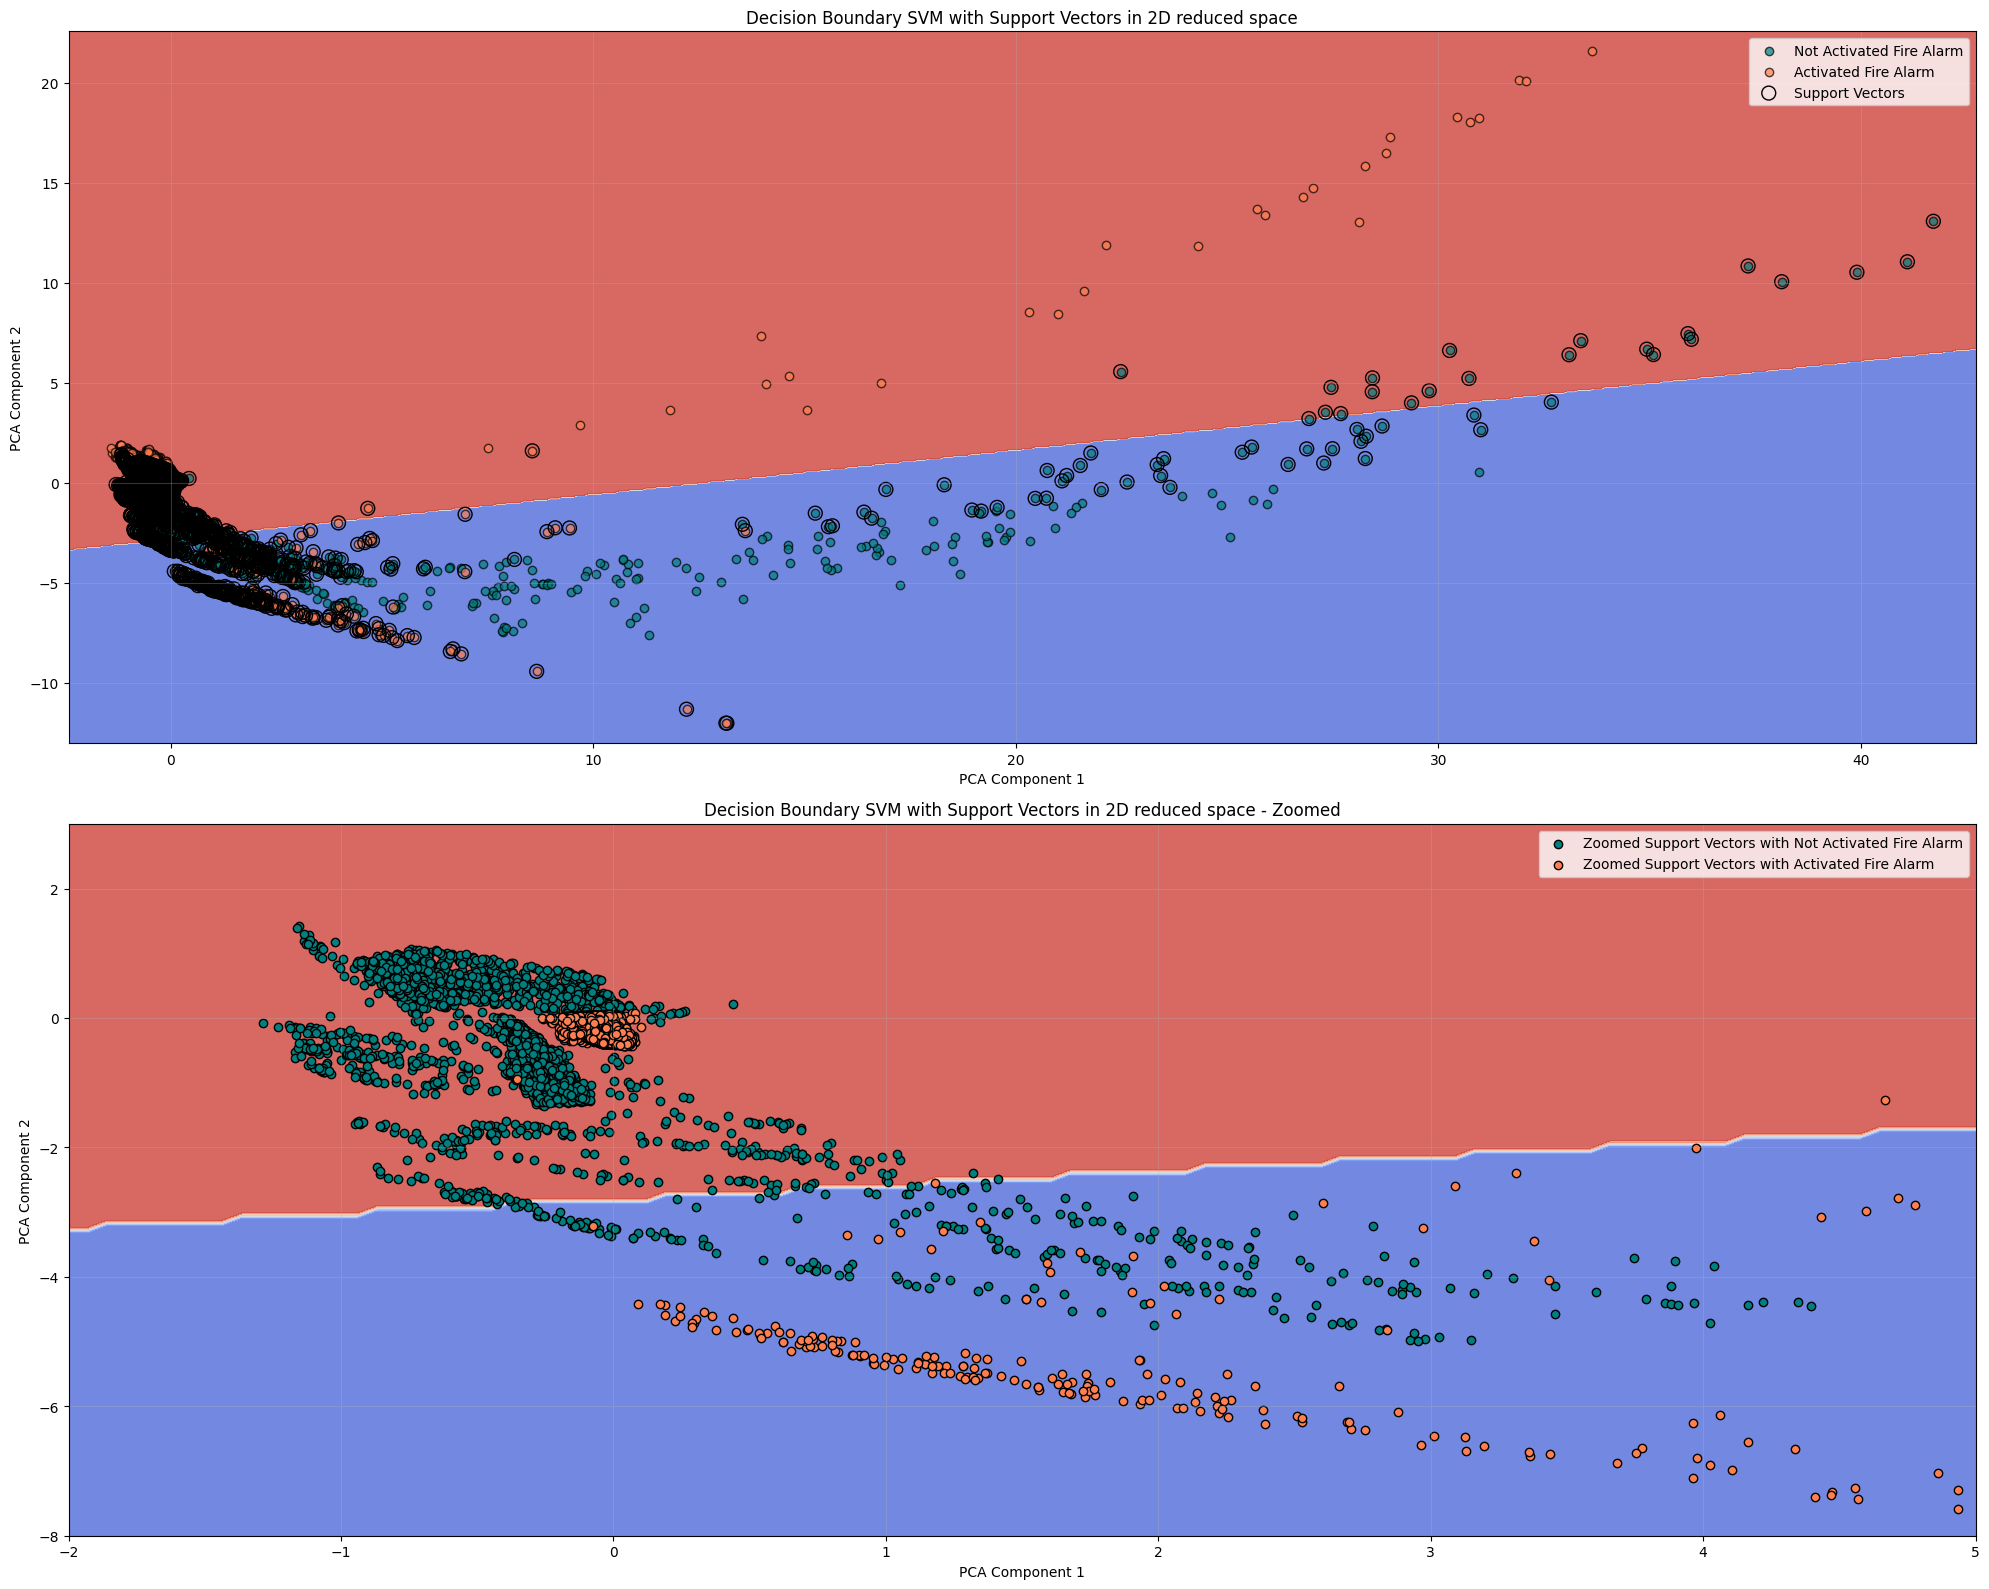

In [130]:
print_svm_model("linear")

-- Standard Dimensions --
SVC_PolyKernel_12Features:
Training Ratio: 1.0 over Standard Training Set
Total Features: 12
Scaling: True
Accuracy: 91.12%
Training Time: 26.81 seconds
-- Dimensionality Reduction --
SVC_PolyKernel_2Features:
Training Ratio: 0.4 over Standard Training Set
Total Features: 2
Scaling: True
Accuracy: 72.71%
Training Time: 294.21 seconds


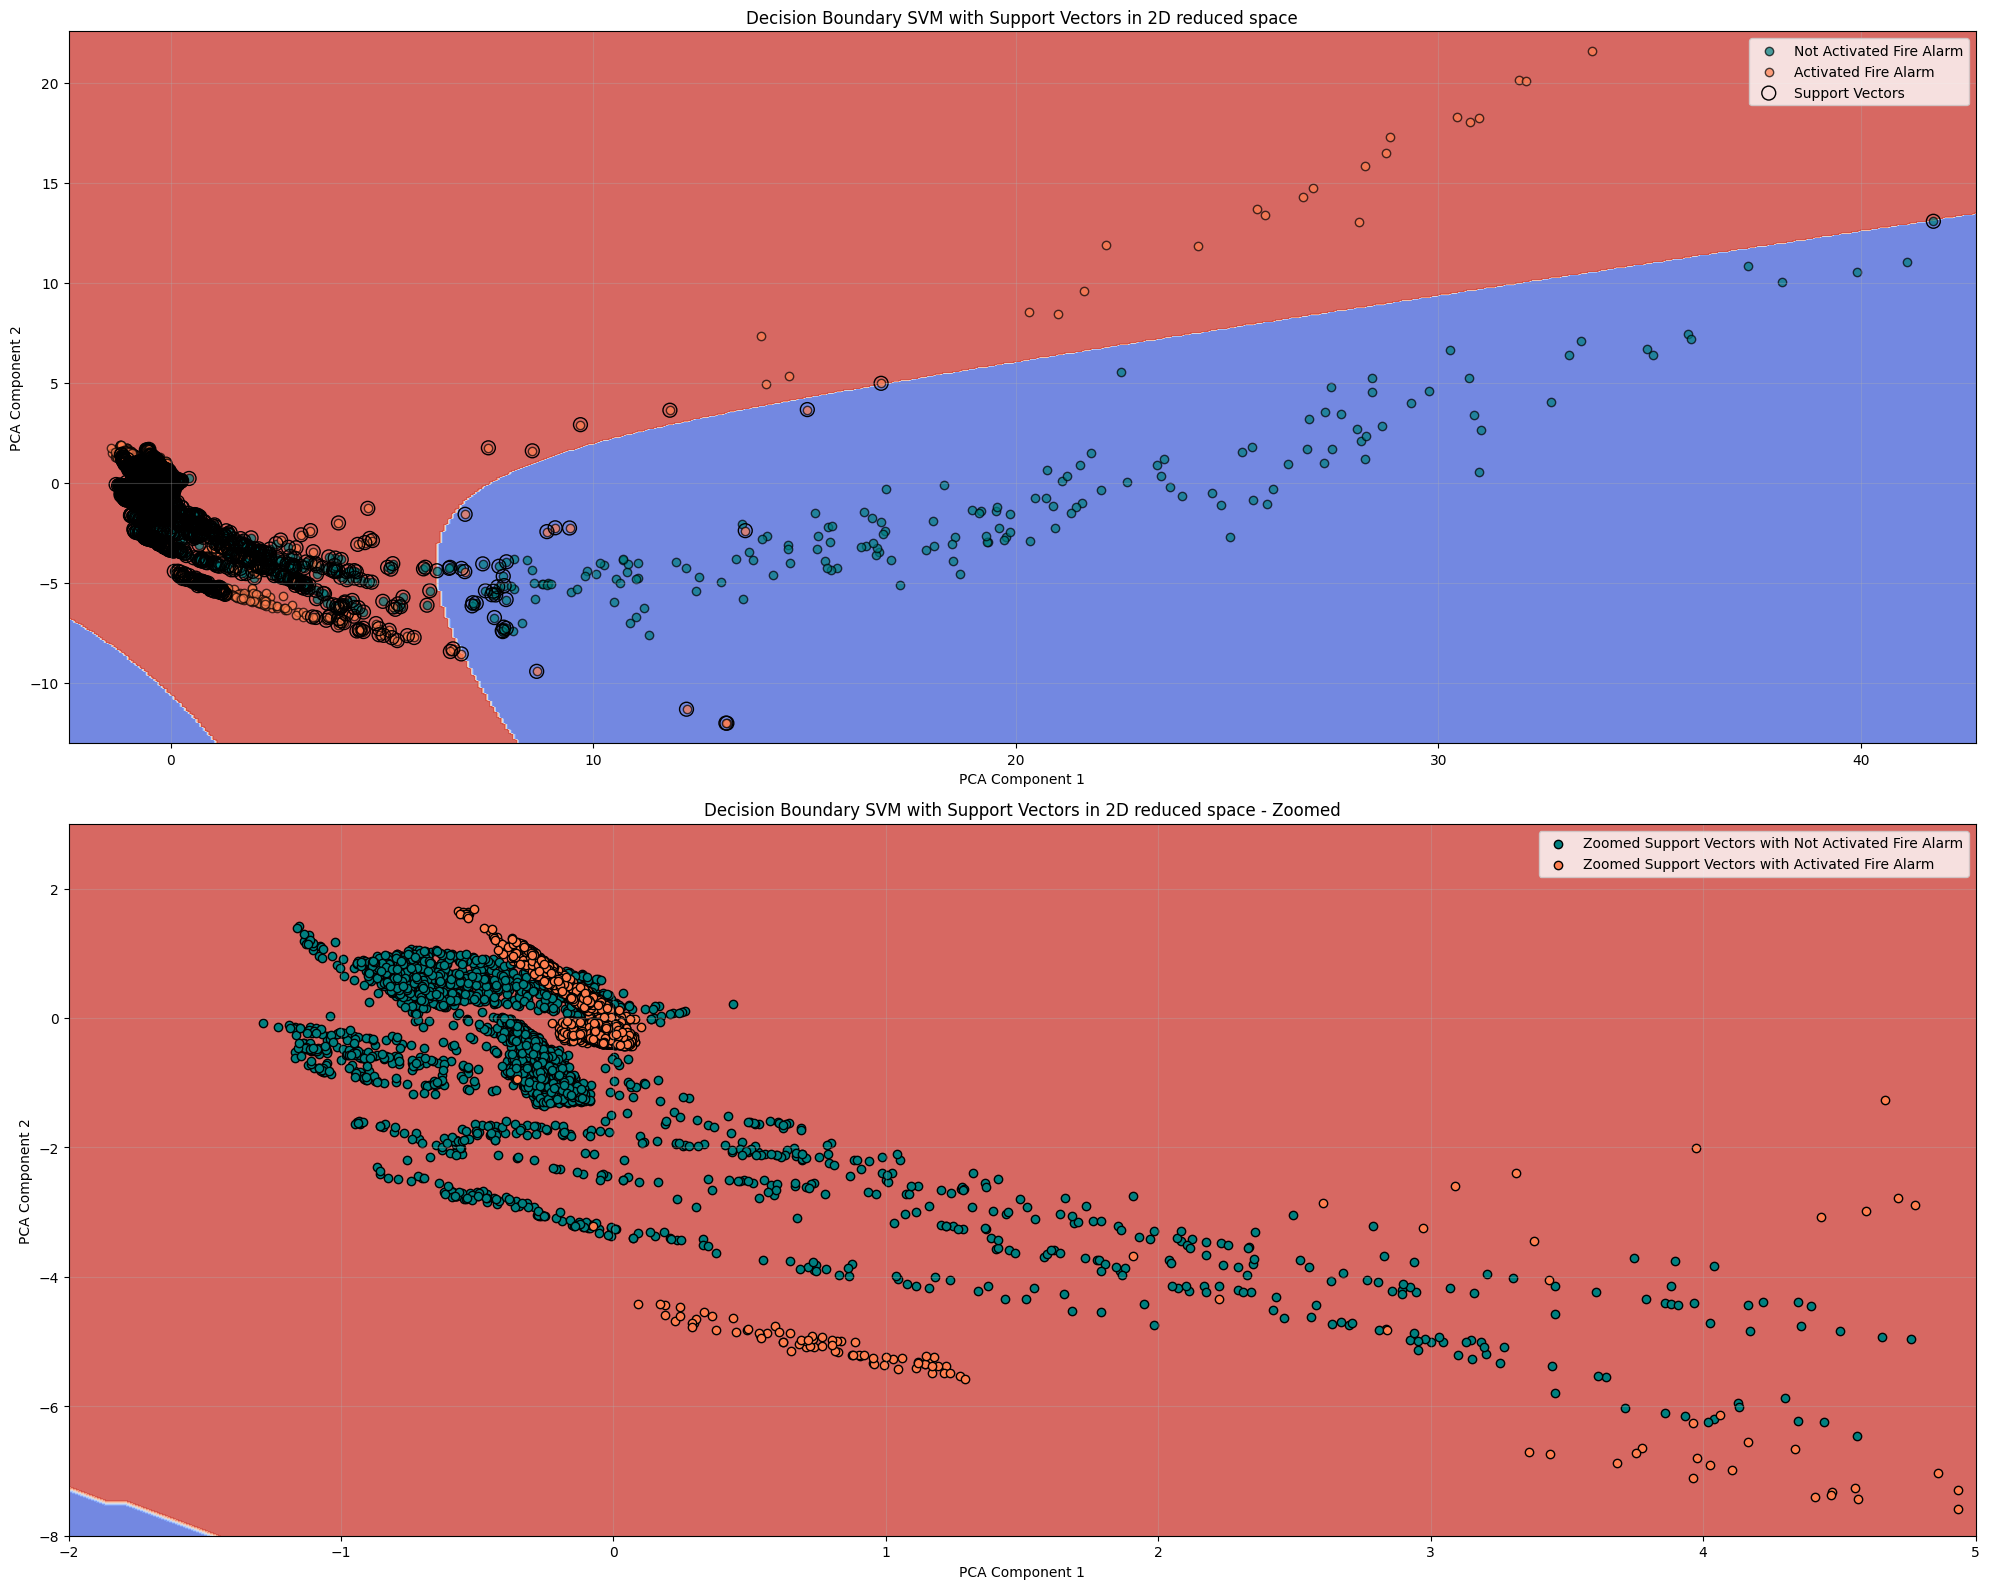

In [97]:
print_svm_model("poly")

-- Standard Dimensions --
SVC_RbfKernel_12Features:
Training Ratio: 1.0 over Standard Training Set
Total Features: 12
Scaling: True
Accuracy: 96.67%
Training Time: 8.17 seconds
-- Dimensionality Reduction --
SVC_RbfKernel_2Features:
Training Ratio: 0.4 over Standard Training Set
Total Features: 2
Scaling: True
Accuracy: 89.83%
Training Time: 1.94 seconds


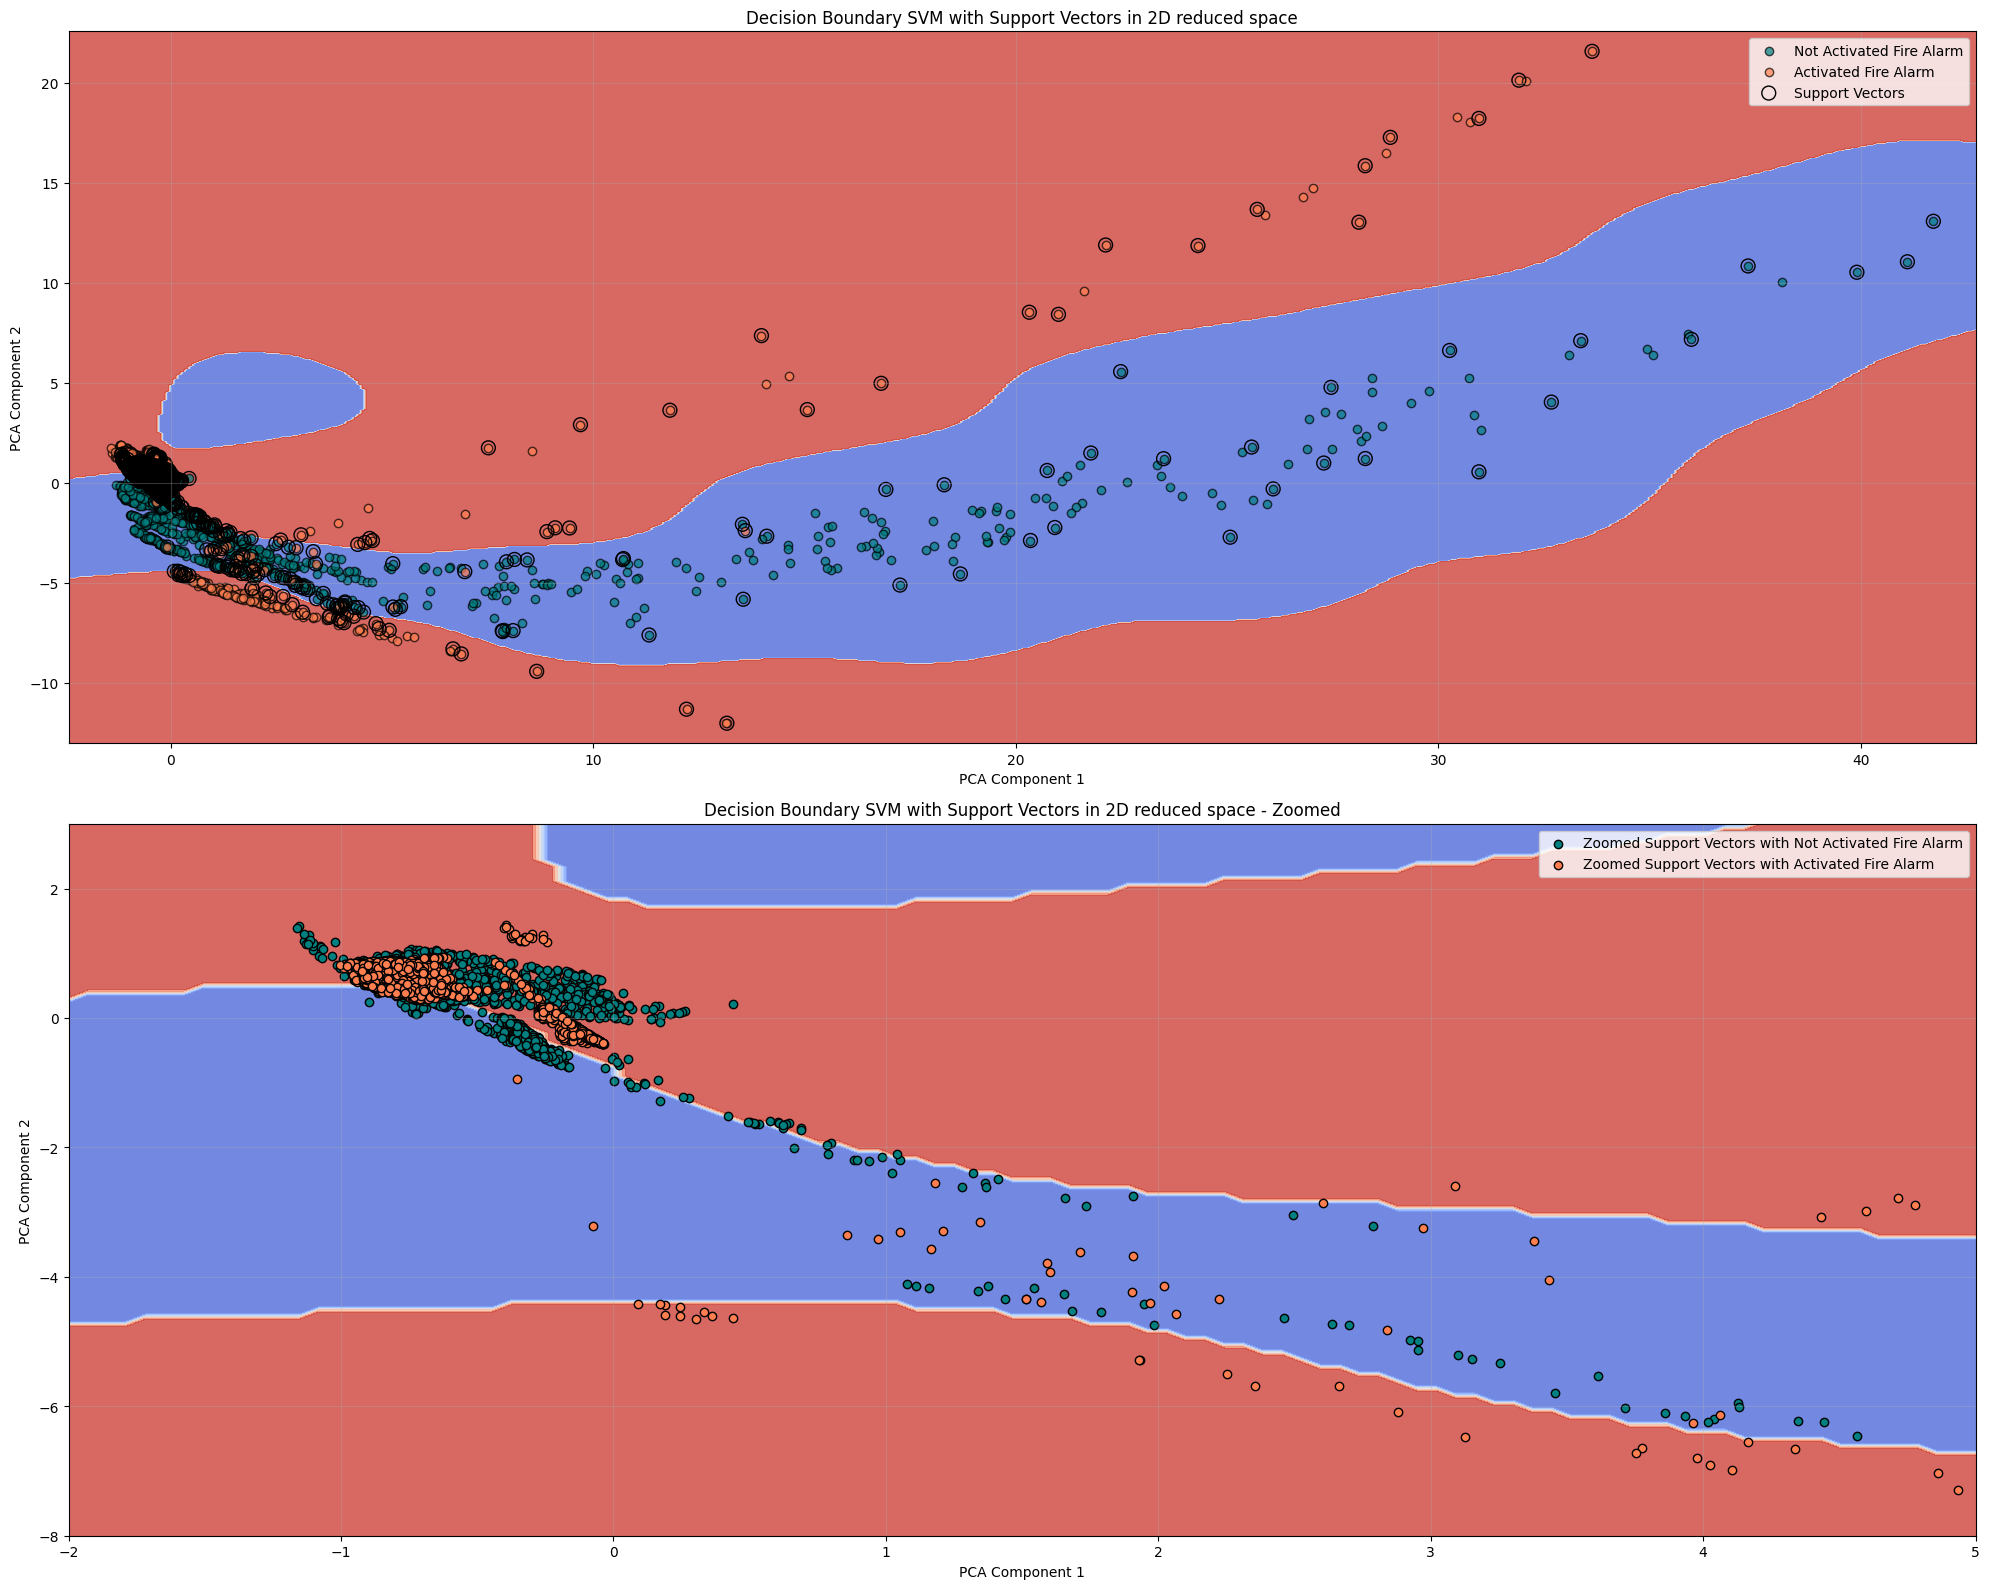

In [98]:
print_svm_model("rbf")

-- Standard Dimensions --
SVC_SigmoidKernel_12Features:
Training Ratio: 1.0 over Standard Training Set
Total Features: 12
Scaling: True
Accuracy: 68.87%
Training Time: 32.20 seconds
-- Dimensionality Reduction --
SVC_SigmoidKernel_2Features:
Training Ratio: 0.4 over Standard Training Set
Total Features: 2
Scaling: True
Accuracy: 61.72%
Training Time: 7.93 seconds


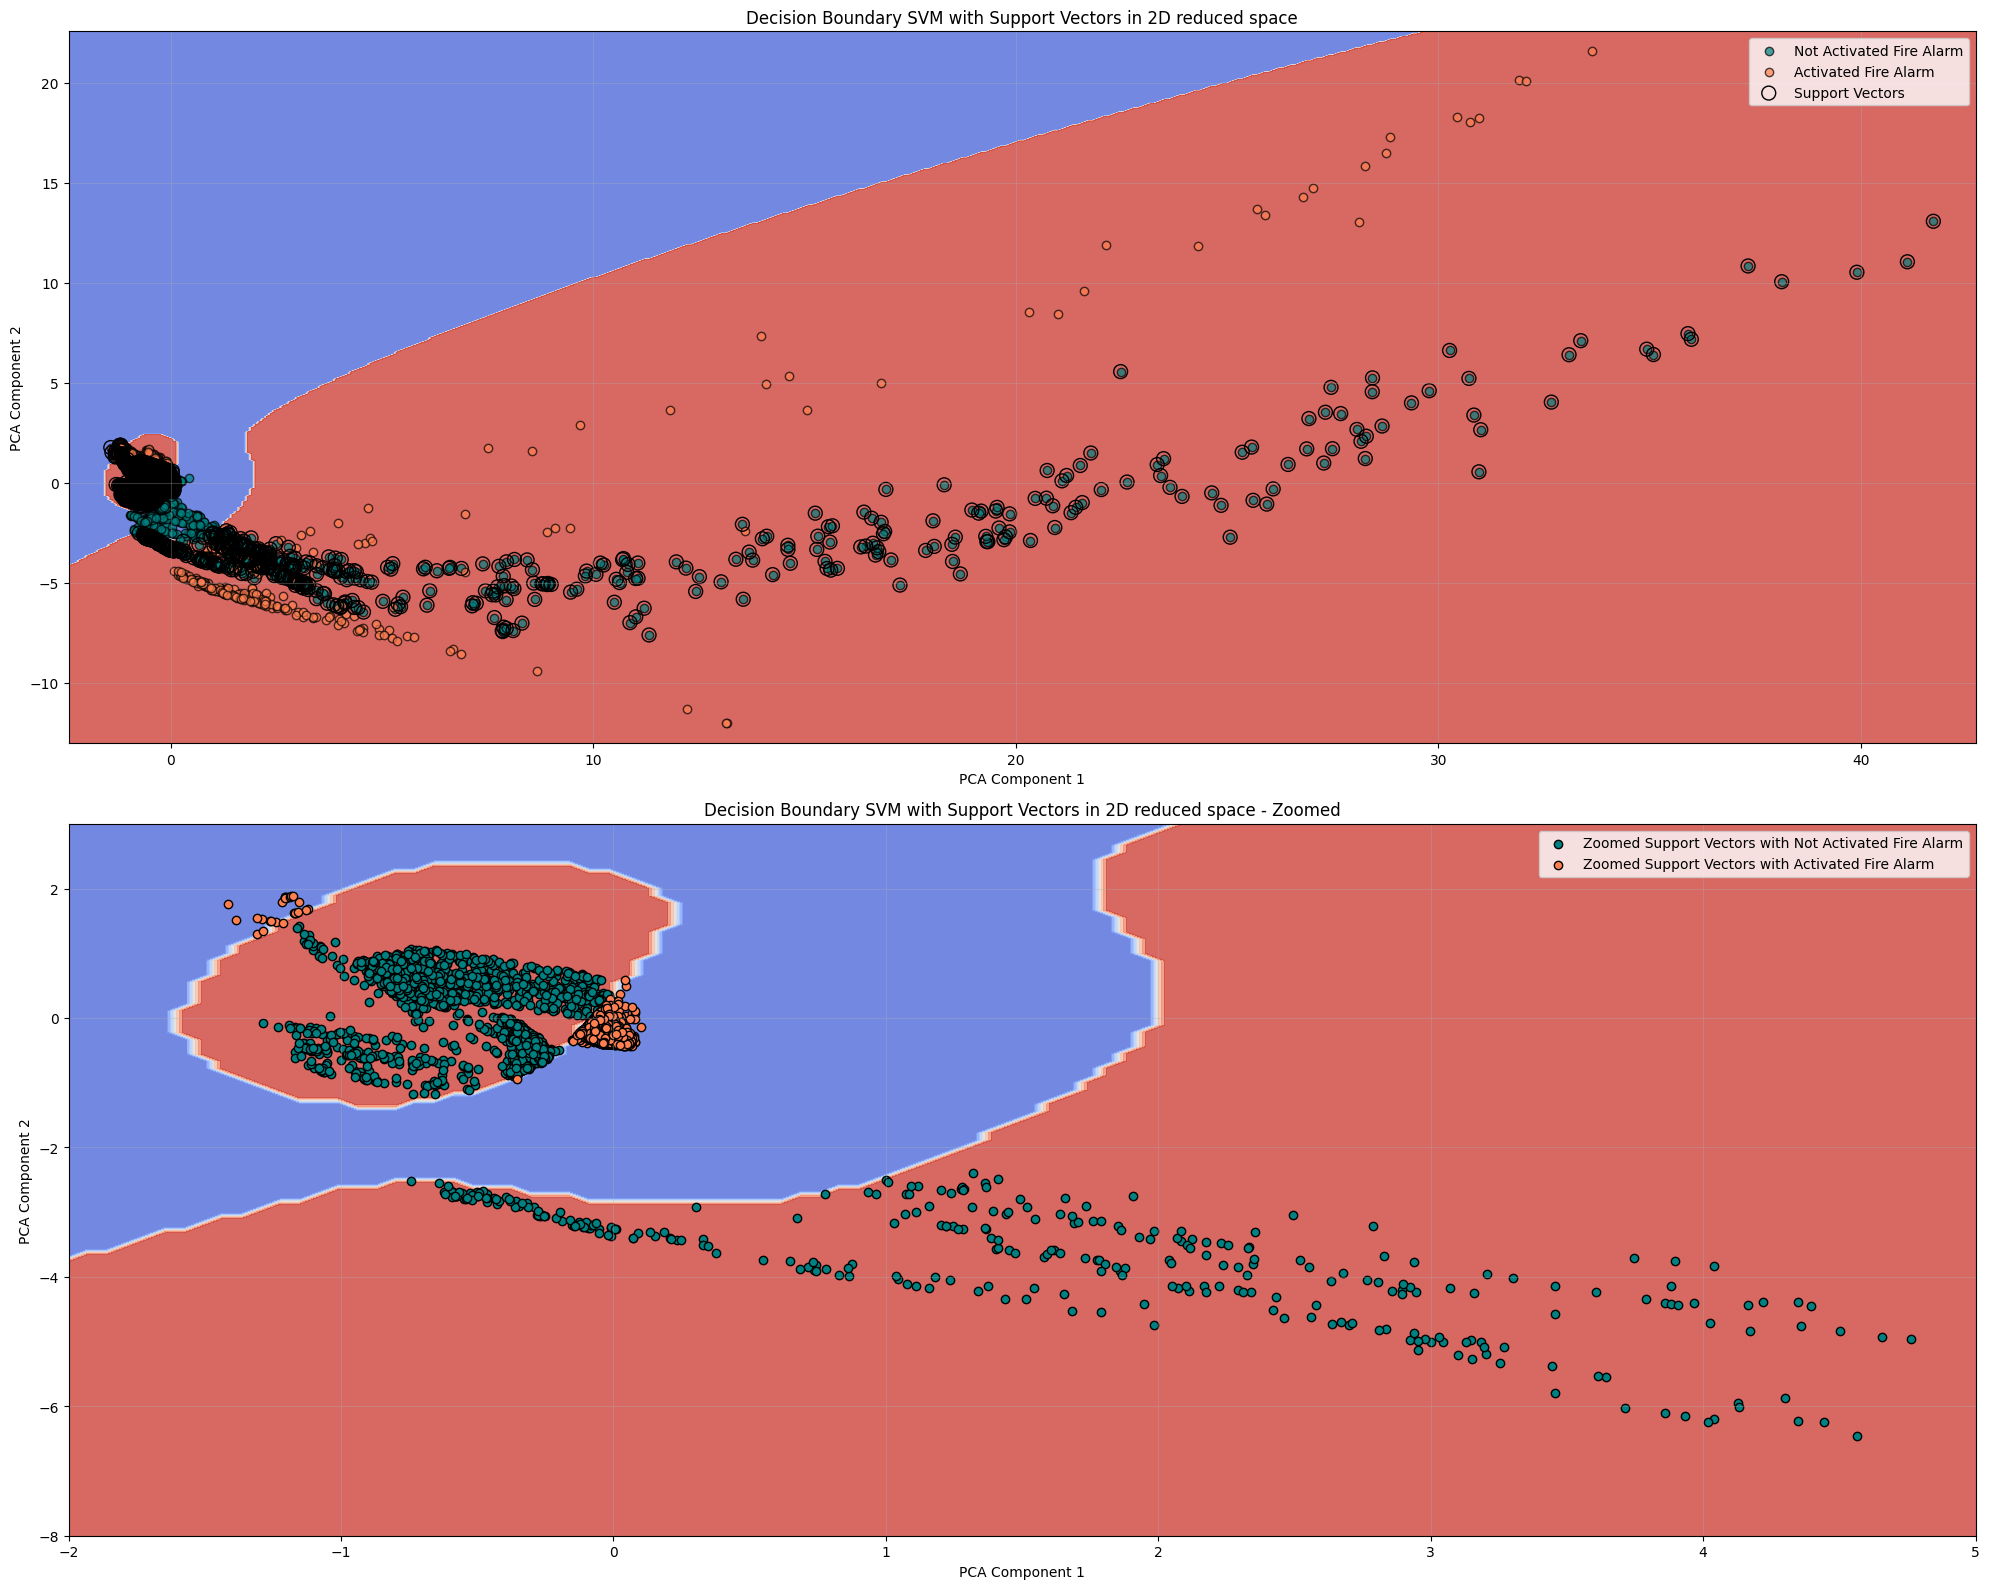

In [99]:
print_svm_model("sigmoid")

# Neural Networks

Come abbiamo visto dai precedenti modelli di machine learning, le feature possono essere ben separabili dai Decision Tree.

Supponiamo quindi che una semplice rete neurale possa avere lo stesso effetto, facendoci ottenere buoni risultati.
Come primo step, importiamo `tensorflow` con `keras`, ovvero le librerie che utilizzeremo.

In [131]:
import tensorflow as tf

ModuleNotFoundError: No module named 'tensorflow'